<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
<b>Notebook analyzing HSC 2021 diffim sprint with refactored `ip_diffim`</b> <br>
Contact author: Bruno Sánchez<br>
Last verified to run: 25 June 2023<br>
LSST Science Piplines version: w_2023_07<br>

**DM-37957: ApPipeWithFakes on HSC COSMOS, Feb 2023**  
**DM-37959: ApPipeWithFakes on HSC COSMOS, Feb 2023**  
**DM-38186: ApPipeWithFakes on HSC COSMOS, Feb 2023**  

## Run details

Baseline run in comparison with convolution mode auto and pre-convolution

* Used weekly `w_2023_07`
* Working directory on USDF. is `/sdf/group/rubin/user/bos/DM-37957`
* Templates are in `u/kherner/DM-33911/templates_bestThirdSeeing`
* Final processing of HSC COSMOS is in `u/bos/DM-37957/w_2023_07_default`
* ApDB is `u/bos/apdb_bosdm37597.sqlite`

For ApPipeWithFakes.yaml:
```
inCollection:
dataQuery: "exposure IN (11690, 11692, 11694, 11696, 11698, 11700, 11702, 11704, 11706, 11708, 11710, 29340, 1204, 1208, 1214, 1216, 1218, 1220, 23692, 23694, 23704, 23718) AND detector in (49, 50, 57, 58, 65, 66)"
```

## Table of Contents

1. [Sources detected on DIA](#sectionA)
2. [Fake Source Analysis](#sectionB)
3. [Analysis on the sensor](#sectionC)
4. [Templates PSF](#sectionD)

### 1. Main package imports

In [1]:
import os
import importlib
import pprint

In [2]:
import matplotlib.pyplot as plt
#%matplotlib widget
%matplotlib inline

import numpy as np
import pandas as pd

In [3]:
import astropy.units as u
from astropy.coordinates import SkyCoord

In [4]:
import lsst.afw.display as afwDisplay
import lsst.geom

import lsst.daf.butler as dafButler

In [5]:
!setup -kr ${HOME}/u/analysis_ap #-t w_2023_07

In [6]:
from lsst.analysis.ap import apdb

In [7]:
from lsst.analysis.ap import legacyApdbUtils as utils
from lsst.analysis.ap import legacyPlotUtils as plac

In [8]:
from astropy.table import Table

In [9]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

importlib.reload(utils)

<module 'lsst.analysis.ap.legacyApdbUtils' from '/home/b/bos/u/analysis_ap/python/lsst/analysis/ap/legacyApdbUtils.py'>

### 2. Data access config
We are comparing three runs now, so we have to define where to find the data and the APDBs for each run.

In [10]:
month = 'February'
year = '2023'

#### Keys for default run.

In [11]:
repo = '/repo/main'
collections = 'u/bos/DM-37957/w_2023_07_default'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='sqlite'
dbName='/sdf/data/rubin/user/bos/DM-37957/apdb_bosdm37597.sqlite'

reader = apdb.ApdbSqliteQuery(dbName, butler=butler, instrument='HSC')

In [12]:
default_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [13]:
default_run['run_name'] = 'Default'

#### This set is for automode

In [14]:
repo = '/repo/main'
collections = 'u/bos/DM-38186/w_2023_07_automode'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='sqlite'
dbName='/sdf/data/rubin/user/bos/DM-38186/apdb_bosdm38186.sqlite'

reader = apdb.ApdbSqliteQuery(dbName, butler=butler, instrument='HSC')

In [15]:
automod_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [16]:
automod_run['run_name'] = 'Convolution-Auto'

#### This set is for pre-convolution

In [17]:
repo = '/repo/main'
collections = 'u/bos/DM-37959-HTCondor-preconv'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

butler = dafButler.Butler(repo, collections=collections)

dbType='postgres'
dbName = 'bos_dm37959_preconv_w2023_07'

reader = apdb.ApdbPostgresQuery(dbName, butler=butler, instrument='HSC')

In [18]:
preconv_run = {
    'repo': repo,
    'collections': collections,
    'instrument': instrument,
    'skymap': skymap,
    'butler': butler,
    'dbType': dbType,
    'dbName': dbName,
    'reader': reader
}

In [19]:
preconv_run['run_name'] = 'Pre-convolution'

## A. Analysis of Sources

### 3. Number of detections
Now loading the tables to compare among them

In [20]:
default_run['robjTable'] = default_run['reader'].load_objects()
default_run['rsrcTable'] = default_run['reader'].load_sources()

In [21]:
automod_run['robjTable'] = automod_run['reader'].load_objects()
automod_run['rsrcTable'] = automod_run['reader'].load_sources()

In [22]:
preconv_run['robjTable'] = preconv_run['reader'].load_objects()
preconv_run['rsrcTable'] = preconv_run['reader'].load_sources()

Look at how many objects and sources we picked right from the reader

In [23]:
n_objs = pd.DataFrame()

In [24]:
n_objs.loc['default', 'n_rdiasrc'] = len(default_run['rsrcTable'])
n_objs.loc['preconv', 'n_rdiasrc'] = len(preconv_run['rsrcTable'])
n_objs.loc['automod', 'n_rdiasrc'] = len(automod_run['rsrcTable'])

In [25]:
n_objs.loc['default', 'n_rdiaobj'] = len(default_run['robjTable'])
n_objs.loc['preconv', 'n_rdiaobj'] = len(preconv_run['robjTable'])
n_objs.loc['automod', 'n_rdiaobj'] = len(automod_run['robjTable'])

In [26]:
n_objs

n_rdiasrc  n_rdiaobj
default    54799.0    54799.0
preconv    60243.0    60243.0
automod    50049.0    50049.0

In [27]:
object_columns = ['diaObjectId', 'ra', 'decl', 'nDiaSources', 'gPSFluxMean', 
                  'rPSFluxMean', 'iPSFluxMean', 'zPSFluxMean', 'yPSFluxMean',
                  'validityEnd', 'flags']

In [28]:
source_columns = ['diaSourceId', 'diaObjectId', 'ra', 'decl', 'ccdVisitId', 'midPointTai',
                  'apFlux', 'psFlux', 'apFluxErr', 'psFluxErr', 'totFlux', 'totFluxErr',
                  'snr', 'x', 'y', 'ixxPSF', 'iyyPSF', 'ixyPSF', 'flags', 'filterName',
                  'visit', 'detector', 'instrument']

Now filter the objects which are not valid and pick the useful columns.

In [29]:
default_run['objTable'] = default_run['robjTable'][default_run['robjTable'].validityEnd.isnull()][object_columns]
automod_run['objTable'] = automod_run['robjTable'][automod_run['robjTable'].validityEnd.isnull()][object_columns]
preconv_run['objTable'] = preconv_run['robjTable'][preconv_run['robjTable'].validityEnd.isnull()][object_columns]

In [30]:
default_run['srcTable'] = default_run['rsrcTable'][source_columns]
automod_run['srcTable'] = automod_run['rsrcTable'][source_columns]
preconv_run['srcTable'] = preconv_run['rsrcTable'][source_columns]

Check numbers once more

In [31]:
n_objs.loc['default', 'n_diasrc'] = len(default_run['srcTable'])
n_objs.loc['preconv', 'n_diasrc'] = len(preconv_run['srcTable'])
n_objs.loc['automod', 'n_diasrc'] = len(automod_run['srcTable'])

In [32]:
n_objs.loc['default', 'n_diaobj'] = len(default_run['objTable'])
n_objs.loc['preconv', 'n_diaobj'] = len(preconv_run['objTable'])
n_objs.loc['automod', 'n_diaobj'] = len(automod_run['objTable'])

In [33]:
n_objs

n_rdiasrc  n_rdiaobj  n_diasrc  n_diaobj
default    54799.0    54799.0   54799.0   33974.0
preconv    60243.0    60243.0   60243.0   41343.0
automod    50049.0    50049.0   50049.0   30926.0

### 4. Flags 
Loading up the flag tables now

In [34]:
badFlagList = [
    'base_PixelFlags_flag_bad',
    'base_PixelFlags_flag_suspect',
    'base_PixelFlags_flag_saturatedCenter',
    'base_PixelFlags_flag_interpolated',
    'base_PixelFlags_flag_interpolatedCenter',
    'base_PixelFlags_flag_edge'
    ]

In [35]:
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig

In [36]:
import functools
import operator

In [37]:
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')

In [38]:
def add_flag_tables(run_dict, badFlagList):
    """
    Unpack the flags and add the resulting tables to the run dictionary
    """
    run_dict['flagValues'] = unpacker.unpack(run_dict['srcTable']['flags'], 'flags')
    run_dict['flagTable'] = pd.DataFrame(run_dict['flagValues'], index=run_dict['srcTable'].index)

    run_dict['srcTableFlags'] = pd.merge(run_dict['srcTable'], run_dict['flagTable'], left_index=True, right_index=True)
    
    badFlags = [run_dict['srcTableFlags'][flag] for flag in badFlagList]
    flagFilter = functools.reduce(operator.or_, badFlags)
    noFlagFilter = ~flagFilter

    run_dict['goodSrc'] = run_dict['srcTableFlags'].loc[noFlagFilter]

    run_dict['goodObjIds'] = set(run_dict['srcTableFlags'].loc[noFlagFilter, 'diaObjectId'])

    run_dict['goodObj'] = run_dict['objTable'].loc[run_dict['objTable']['diaObjectId'].isin(run_dict['goodObjIds'])]
    
    return flagFilter, noFlagFilter

In [39]:
flagFilter, noFlagFilter = add_flag_tables(default_run, badFlagList)
flagFilter, noFlagFilter = add_flag_tables(preconv_run, badFlagList)
flagFilter, noFlagFilter = add_flag_tables(automod_run, badFlagList)

In [40]:
n_objs.loc['default', 'n_good_diaobj'] = len(default_run['goodObj'])
n_objs.loc['preconv', 'n_good_diaobj'] = len(preconv_run['goodObj'])
n_objs.loc['automod', 'n_good_diaobj'] = len(automod_run['goodObj'])

In [41]:
n_objs.loc['default', 'n_good_diasrc'] = len(default_run['goodSrc'])
n_objs.loc['preconv', 'n_good_diasrc'] = len(preconv_run['goodSrc'])
n_objs.loc['automod', 'n_good_diasrc'] = len(automod_run['goodSrc'])

In [42]:
n_objs

n_rdiasrc  n_rdiaobj  n_diasrc  n_diaobj  n_good_diaobj  \
default    54799.0    54799.0   54799.0   33974.0         6166.0   
preconv    60243.0    60243.0   60243.0   41343.0         6381.0   
automod    50049.0    50049.0   50049.0   30926.0         6698.0   

         n_good_diasrc  
default        13244.0  
preconv        10909.0  
automod        13727.0

Text(0, 0.5, 'N')

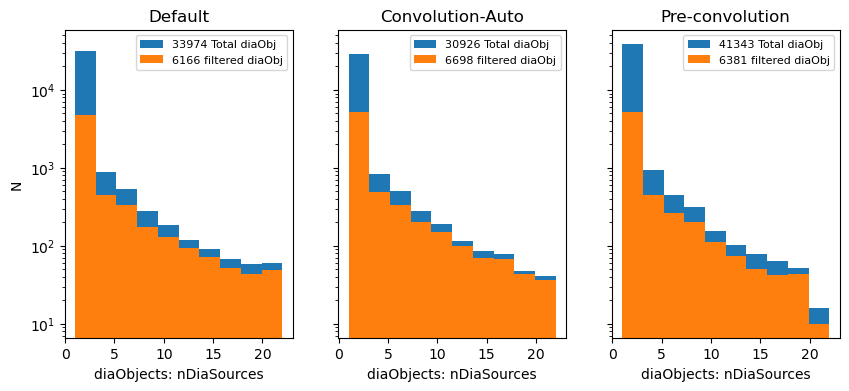

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
for i_run, run_dict in enumerate([default_run, automod_run, preconv_run]):
    #plt.figure(figsize=(12, 8))
    ax = axes.flatten()[i_run]

    ax.hist(run_dict['objTable'].nDiaSources, log=True, label=f"{len(run_dict['objTable'])} Total diaObj")
    #plt.xlabel('diaObjects: nDiaSources')
    #plt.legend(loc='best')

    ax.hist(run_dict['goodObj'].nDiaSources, log=True, label=f"{len(run_dict['goodObj'])} filtered diaObj")
    ax.set_xlabel('diaObjects: nDiaSources')
    ax.legend(loc='best', fontsize=8)
    ax.set_title(run_dict['run_name'])
axes.flatten()[0].set_ylabel('N')

### 5. Sky plots on sources

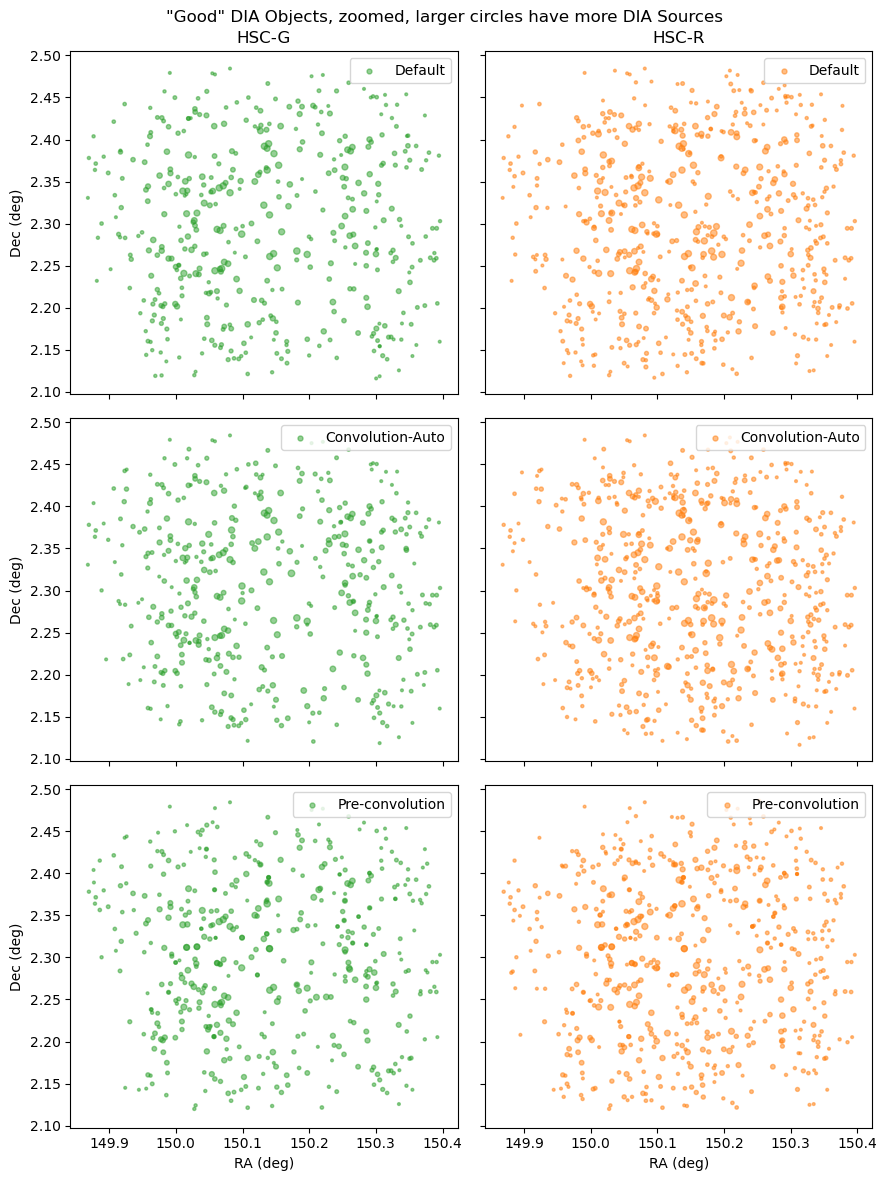

In [44]:
nSrc = 3  # threshold for which DIA Objects to plot (only those with > nSrc constituent DIA Sources)

fig, axs = plt.subplots(3, 2, figsize=(9, 12), sharex=True, sharey=True)

fig.suptitle('"Good" DIA Objects, zoomed, larger circles have more DIA Sources')

for i_run, run_dict in enumerate([default_run, automod_run, preconv_run]):
    #plt.figure(figsize=(12, 8))

    axG = axs[i_run, 0]
    axR = axs[i_run, 1]

    axList = [axG, axR] #, axI, axZ, axY]

    xlim = [149.7, 149.5]
    ylim = [2.7, 2.9]
    #plt.setp(axs, xlim=xlim, ylim=ylim)
    
    goodGFilter = (run_dict['goodObj']['nDiaSources'] > nSrc) & (run_dict['goodObj']['gPSFluxMean'] > 0)
    goodRFilter = (run_dict['goodObj']['nDiaSources'] > nSrc) & (run_dict['goodObj']['rPSFluxMean'] > 0)

    goodFilterList = [goodGFilter, goodRFilter] #, goodIFilter, goodZFilter, goodYFilter]

    axG.set_ylabel('Dec (deg)')
    if i_run==2:
        axG.set_xlabel('RA (deg)')
        axR.set_xlabel('RA (deg)')
    if i_run==0:
        axG.set_title('HSC-G')
        axR.set_title('HSC-R')
    
    colorList = ['C2', 'C1', 'C3', 'C5', 'k']

    for ax, goodFilter, color in zip(axList, goodFilterList, colorList):
        ax.scatter(run_dict['goodObj'].loc[goodFilter, 'ra'],
                   run_dict['goodObj'].loc[goodFilter, 'decl'],
                   s=run_dict['goodObj'].loc[goodFilter, 'nDiaSources'], 
                   c=color, marker='o', alpha=0.5,
                   label=run_dict['run_name'])
    axG.legend(loc='upper right')
    axR.legend(loc='upper right')
plt.tight_layout()

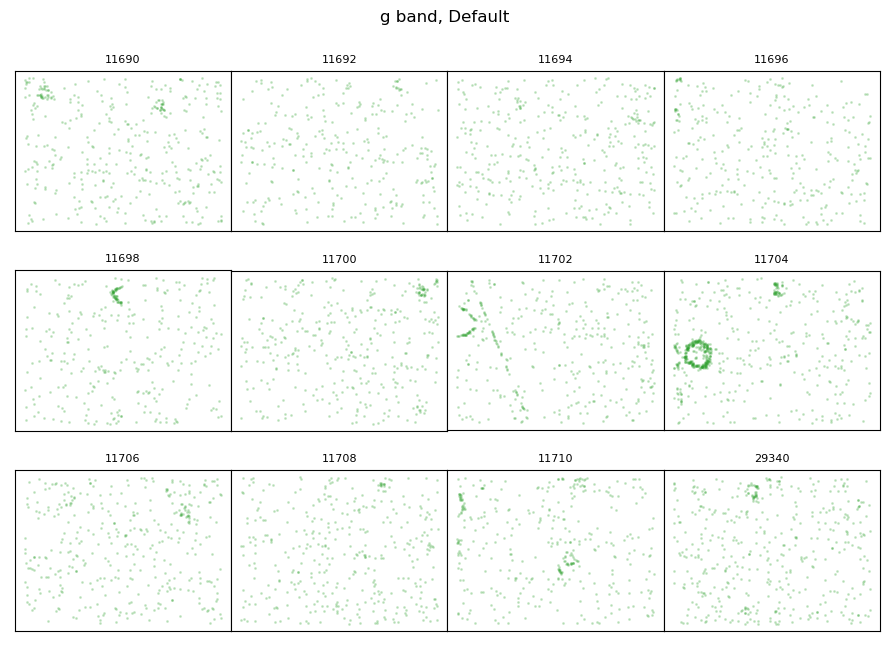

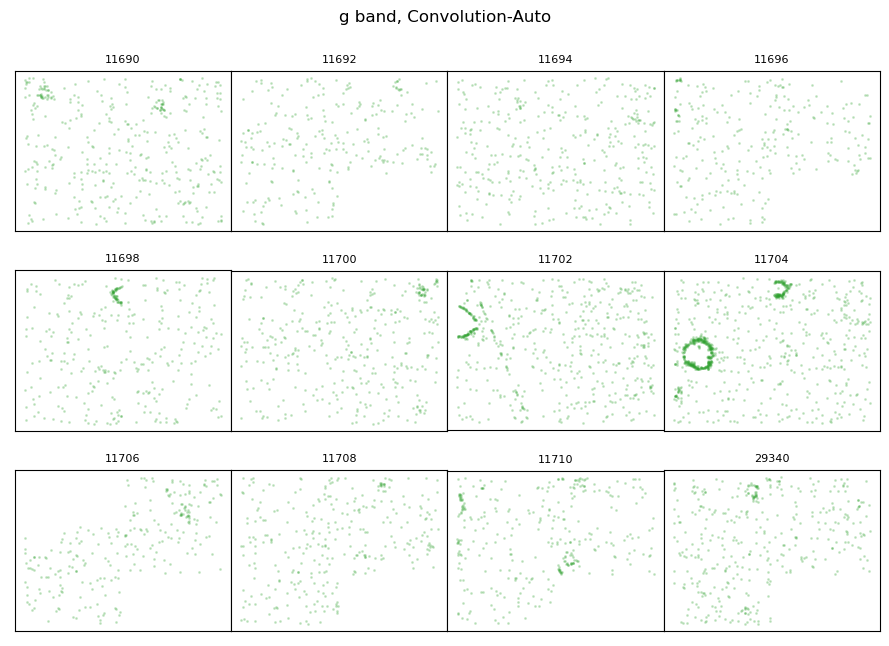

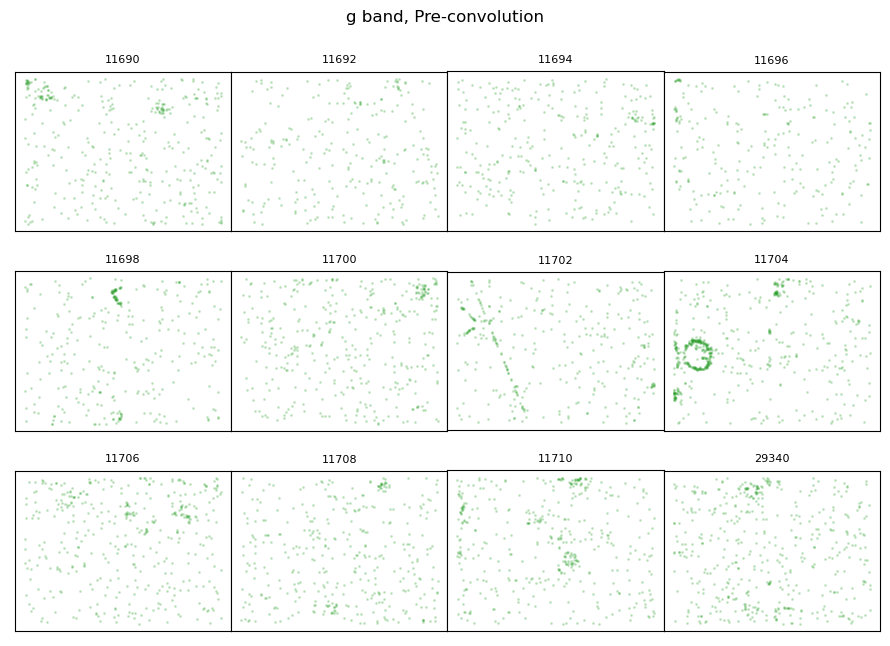

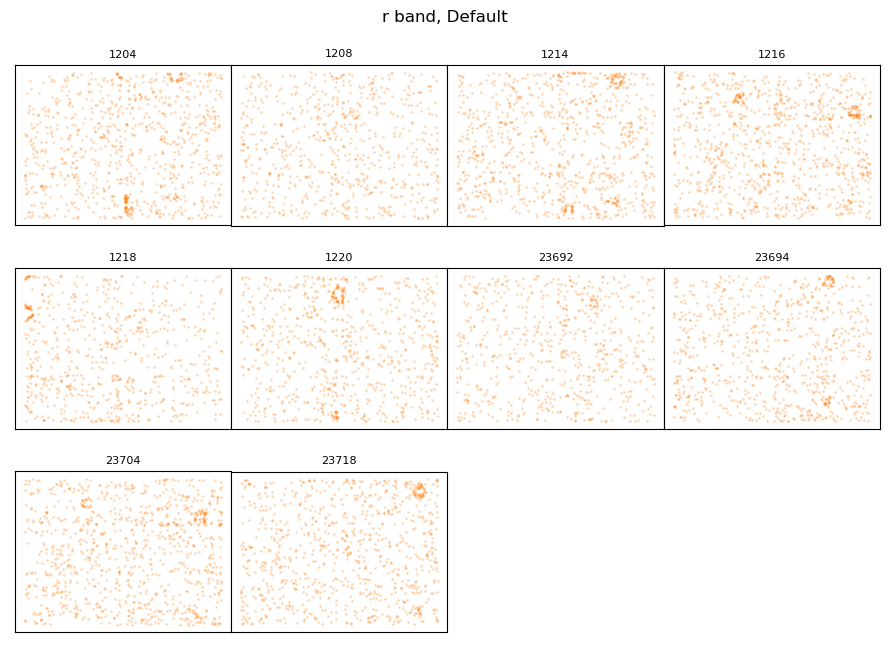

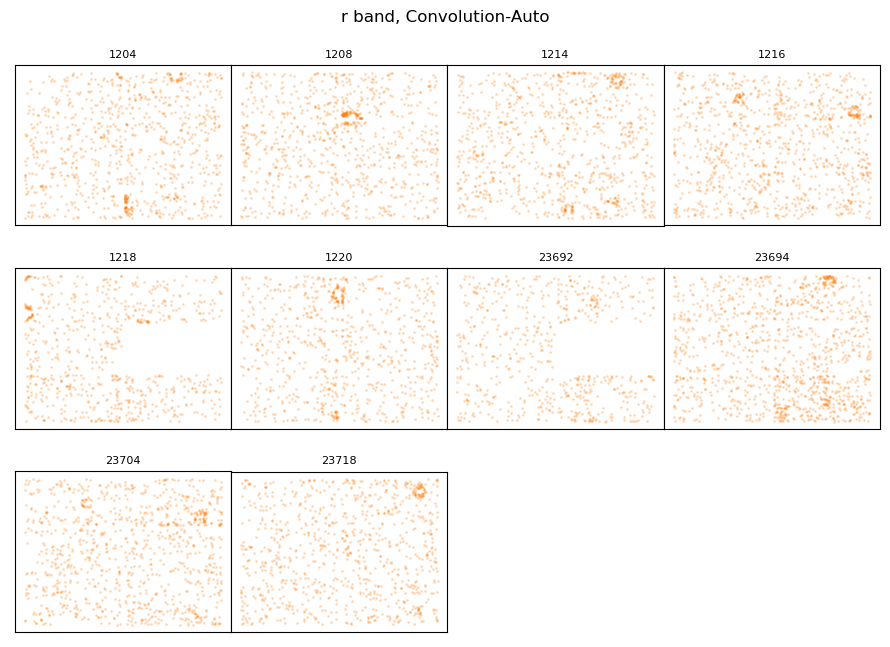

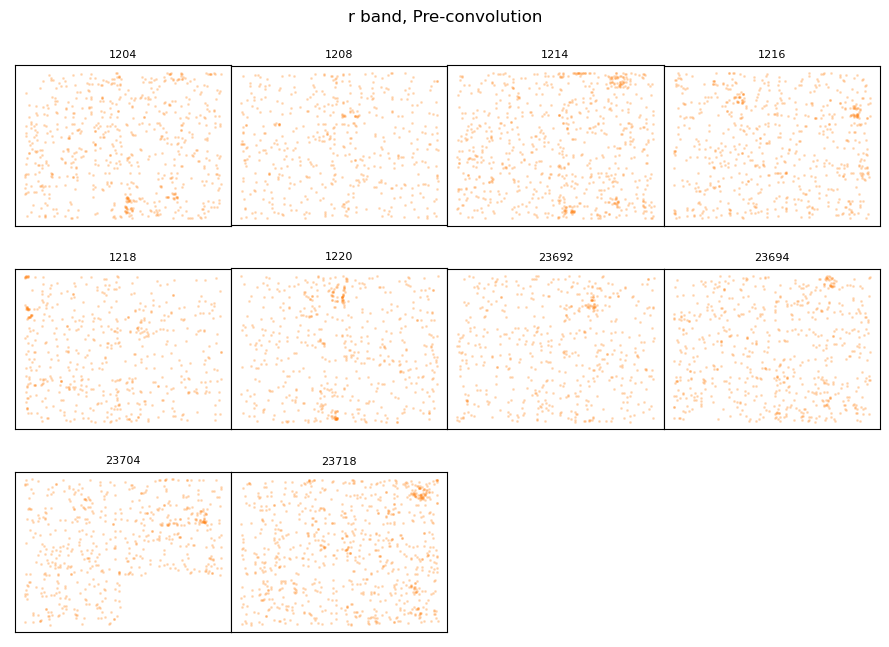

In [45]:
# Note: g band data per visit is sparse
bandList = ['g', 'r', ]
colorList = ['C2', 'C1', ]
size=5

for band, color in zip(bandList, colorList):
    for arun in [default_run, automod_run, preconv_run]:
        repo = arun['repo']
        goodSrc=arun['goodSrc']
        
        plac.plotDiaSourcesOnSkyGrid(
            repo, goodSrc.loc[goodSrc['filterName'] == band], 
            title=band+f" band, {arun['run_name']}", 
            color=color, size=size
        )

### 6. Flux of detections

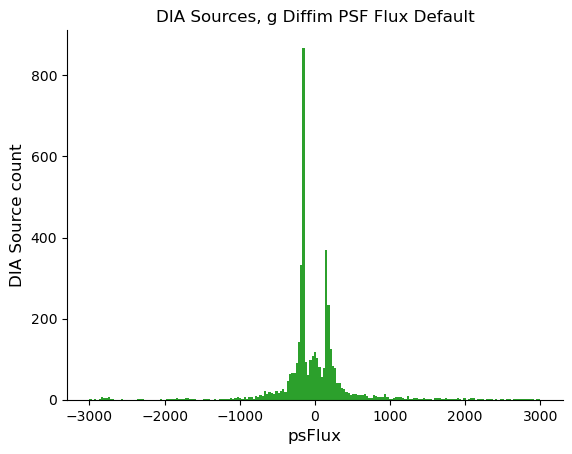

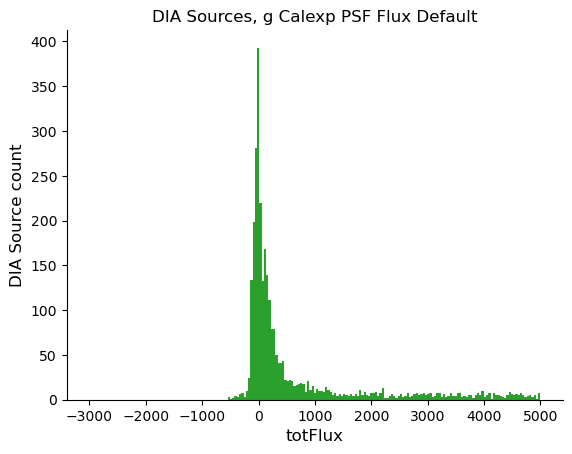

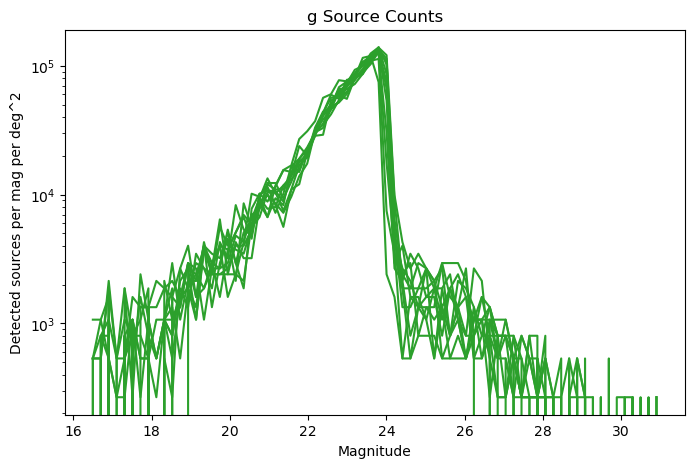

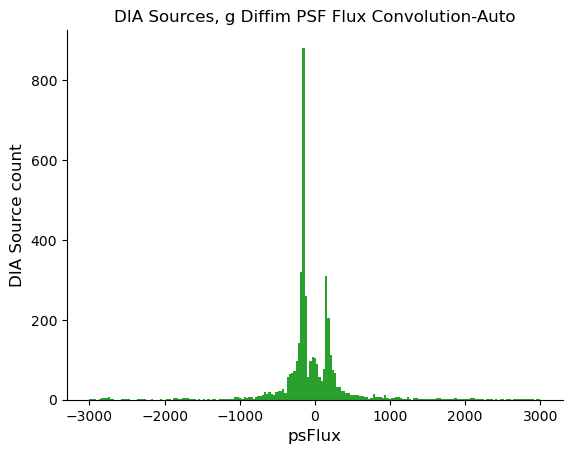

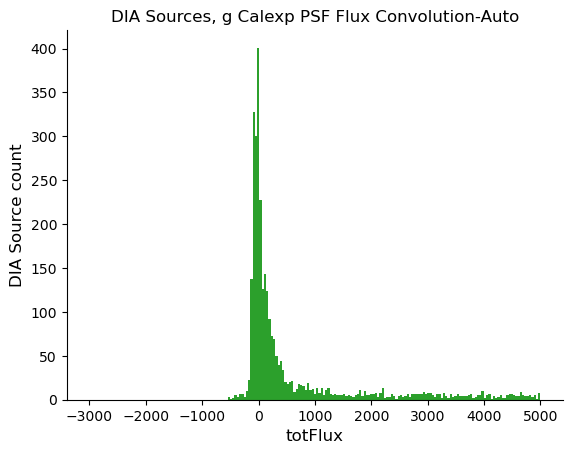

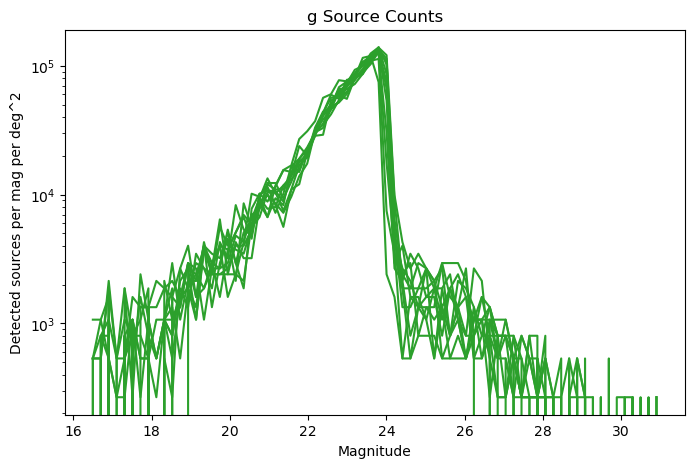

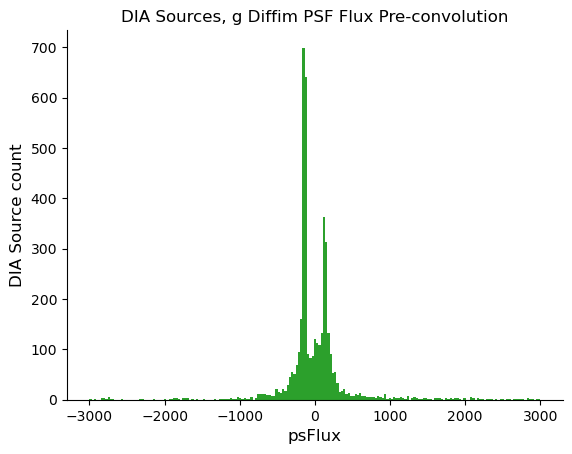

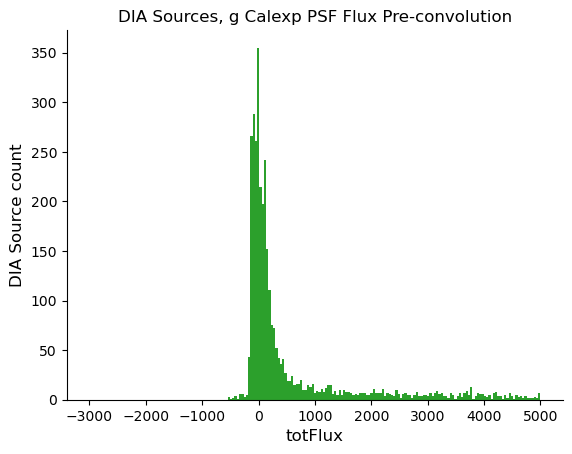

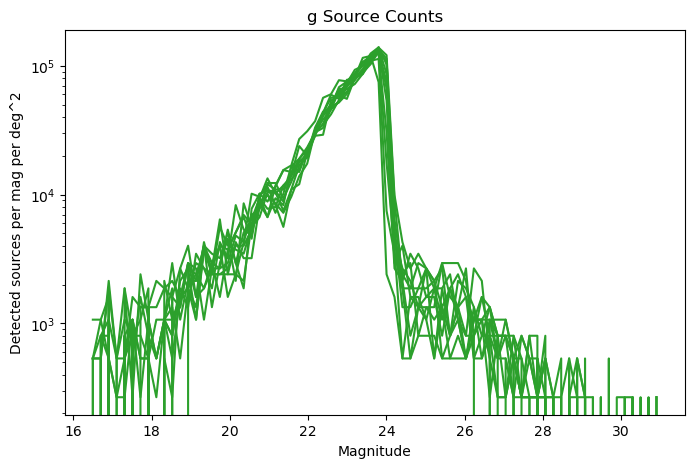

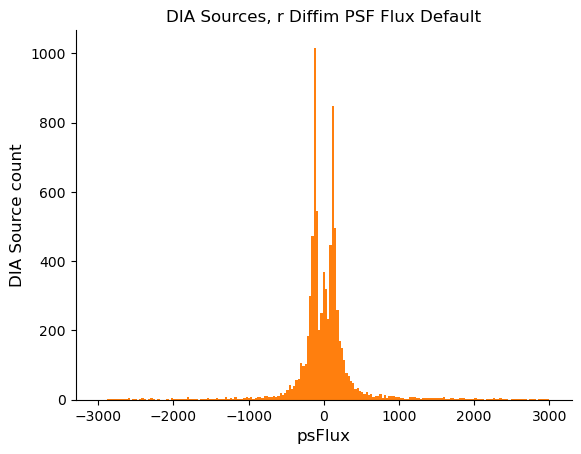

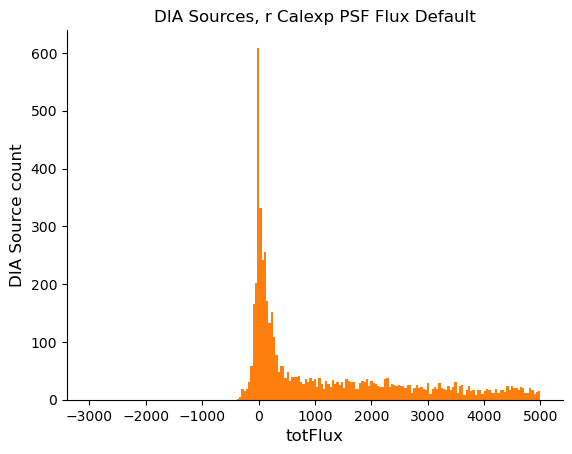

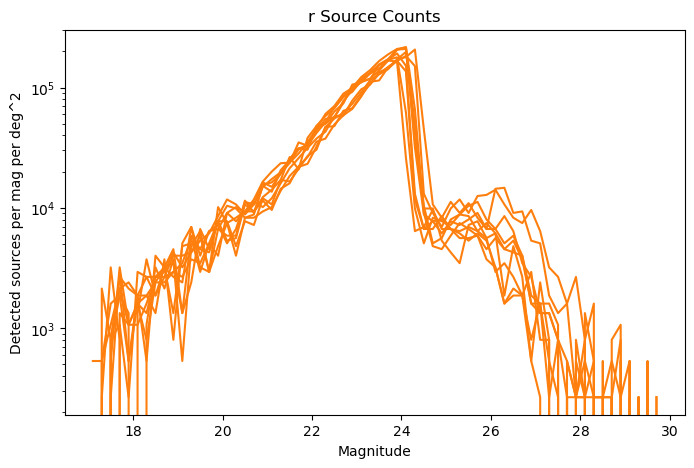

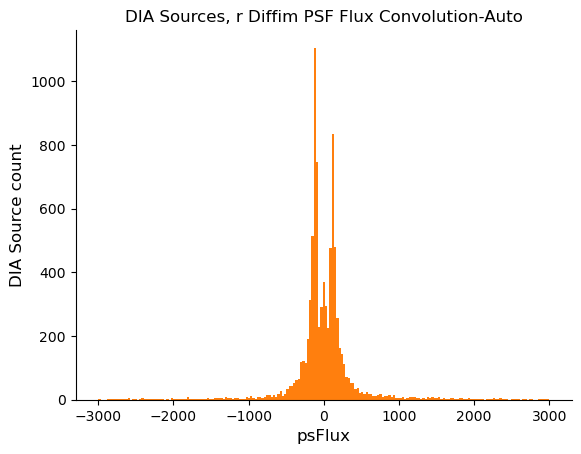

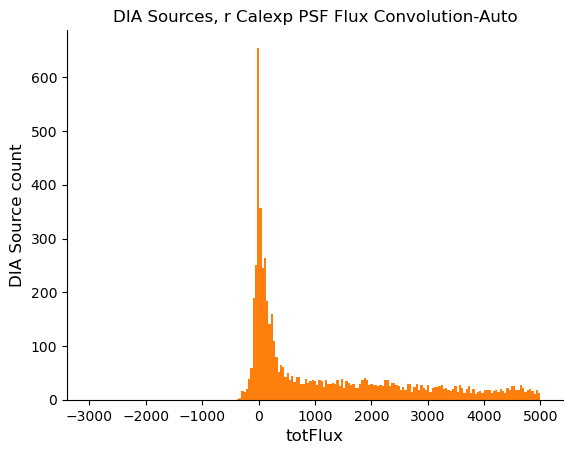

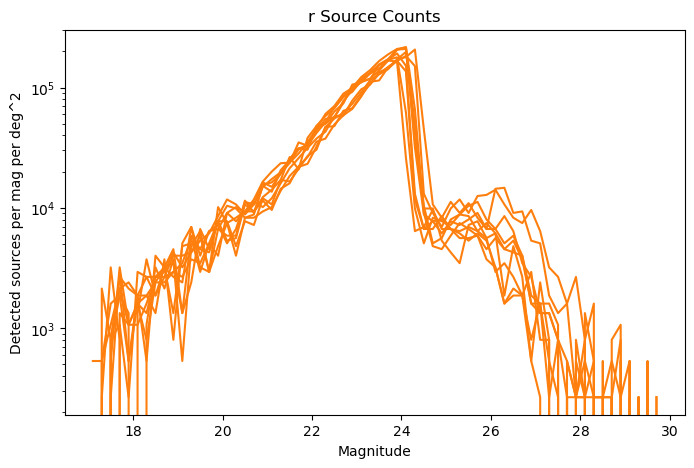

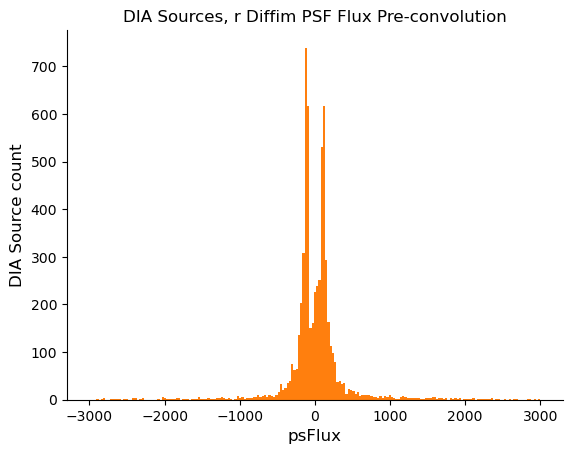

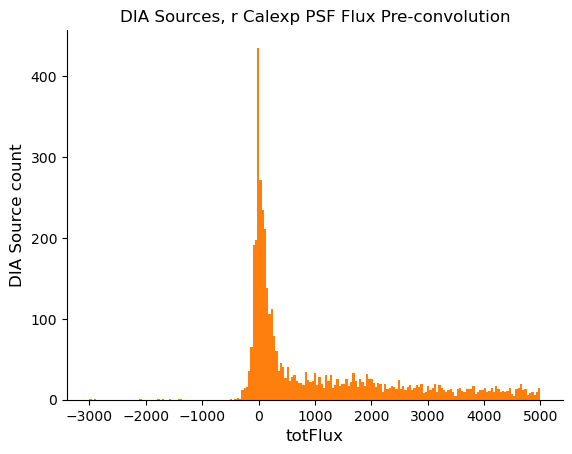

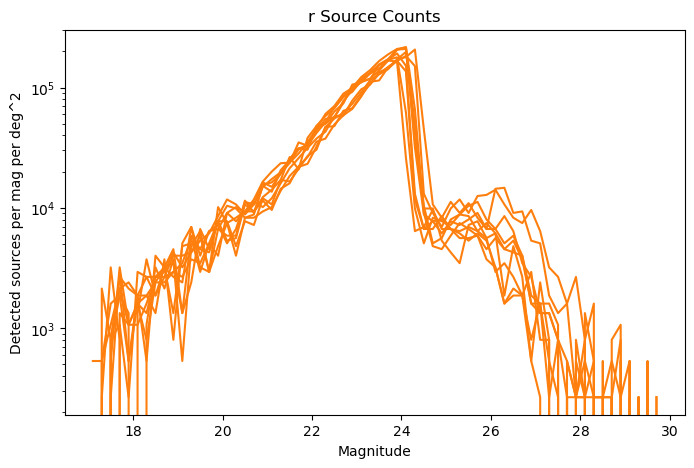

In [46]:
#collection = collections

for band, color in zip(bandList, colorList):
    for arun in [default_run, automod_run, preconv_run]:
        repo = arun['repo']
        goodSrc = arun['goodSrc']
        collections = arun['collections']
        
        plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='psFlux',
                            title=f'DIA Sources, {band} Diffim PSF Flux {arun["run_name"]}', color1=color, binmin=-3e3, binmax=3e3)
        plac.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == band], fluxType='totFlux',
                            title=f'DIA Sources, {band} Calexp PSF Flux {arun["run_name"]}', color1=color, binmin=-3e3, binmax=5e3)
        plac.source_magnitude_histogram(repo, goodSrc, band, 'HSC', collections)

In [47]:
xlim = (150.5, 149.70)
ylim = (1.95, 2.7)

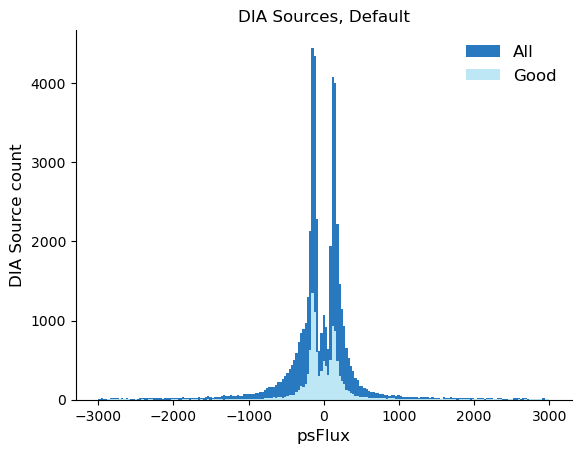

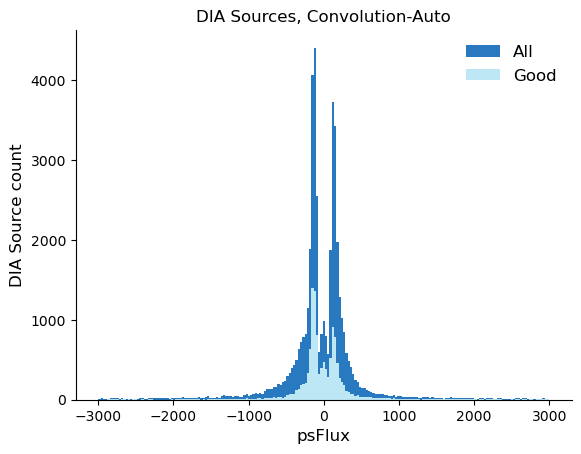

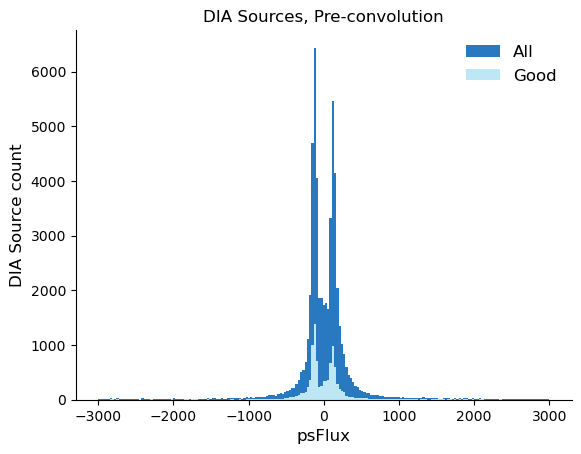

In [48]:
for arun in [default_run, automod_run, preconv_run]:
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    
    plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='psFlux', label1='All', label2='Good',
            title=f'DIA Sources, {arun["run_name"]}')

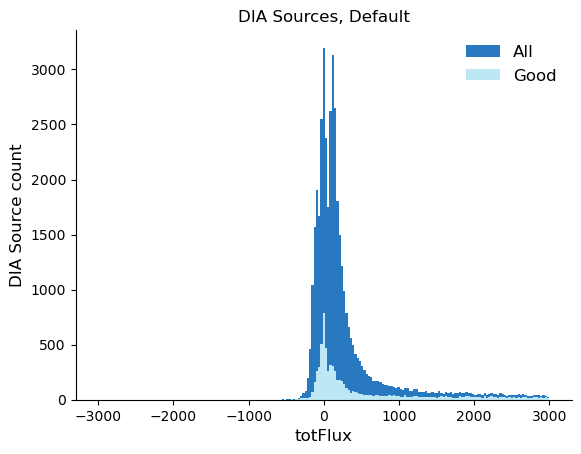

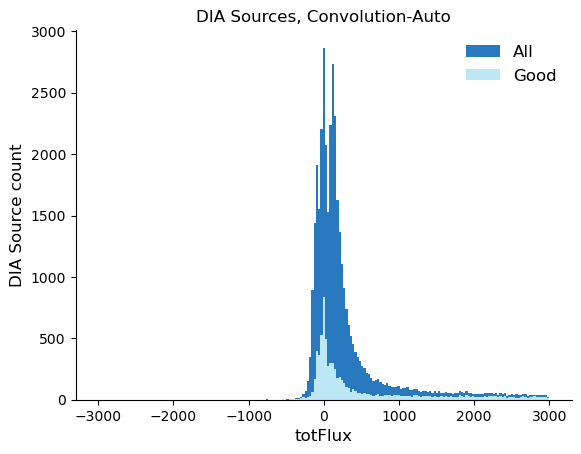

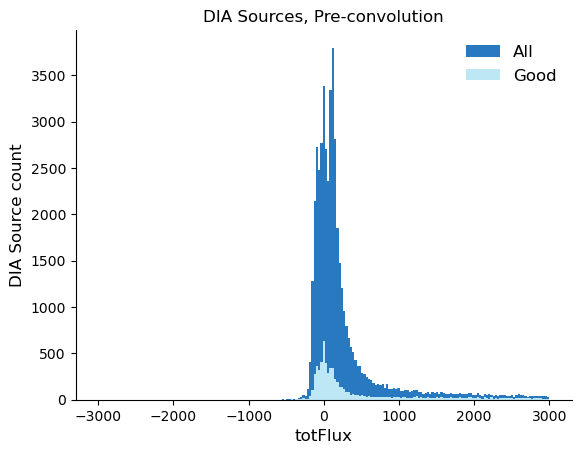

In [49]:
for arun in [default_run, automod_run, preconv_run]:
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    

    plac.plotFluxHistSrc(srcTable, goodSrc, fluxType='totFlux', label1='All', label2='Good',
                    title=f'DIA Sources, {arun["run_name"]}')

### 7. Flag frequency analysis

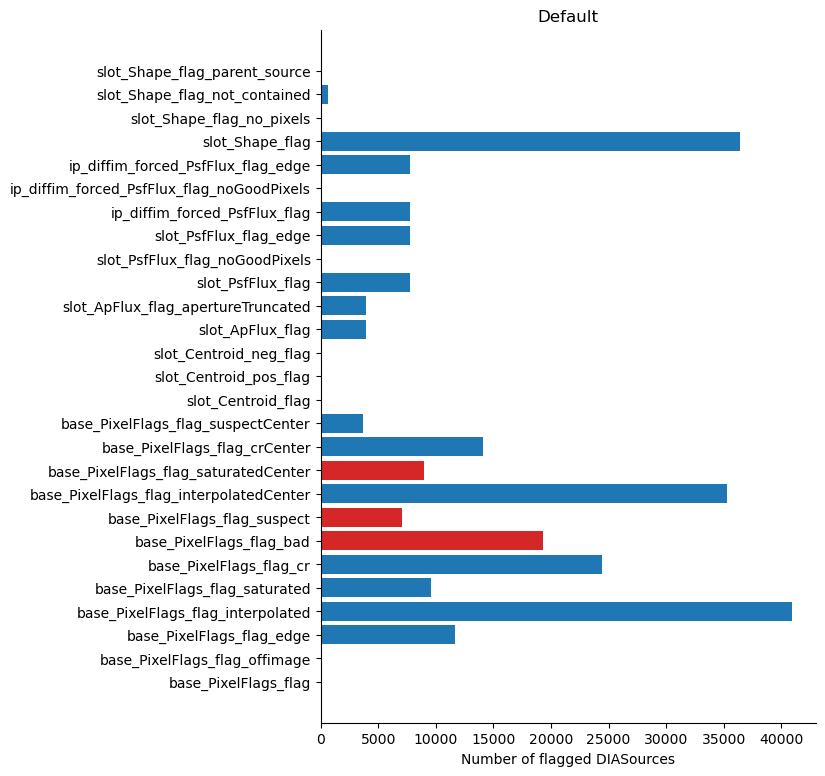

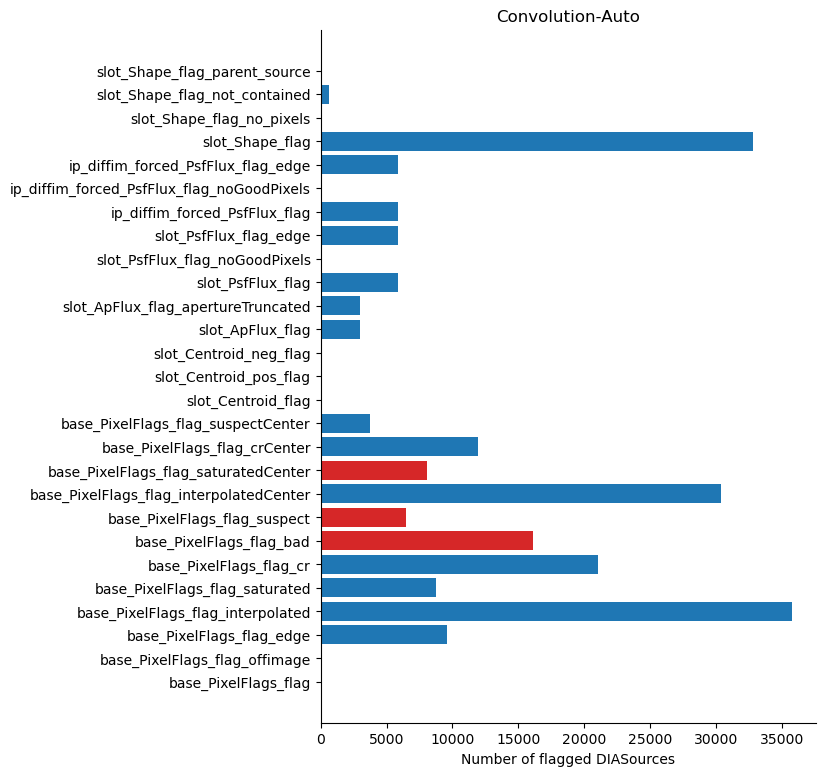

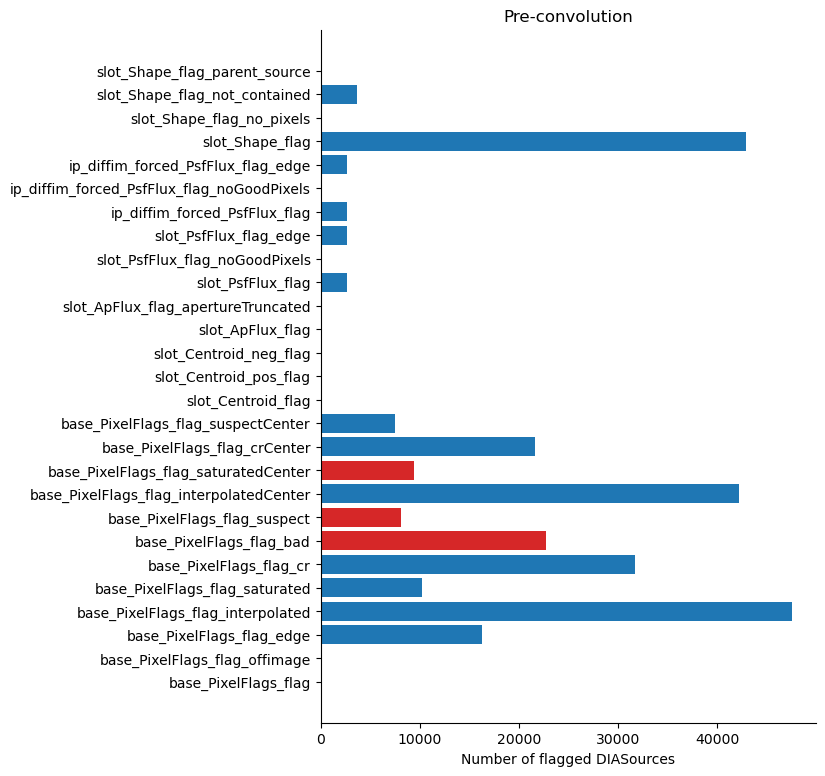

In [50]:
for arun in [default_run, automod_run, preconv_run]:
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    
    plac.plotFlagHist(srcTable, title=f'{arun["run_name"]}')

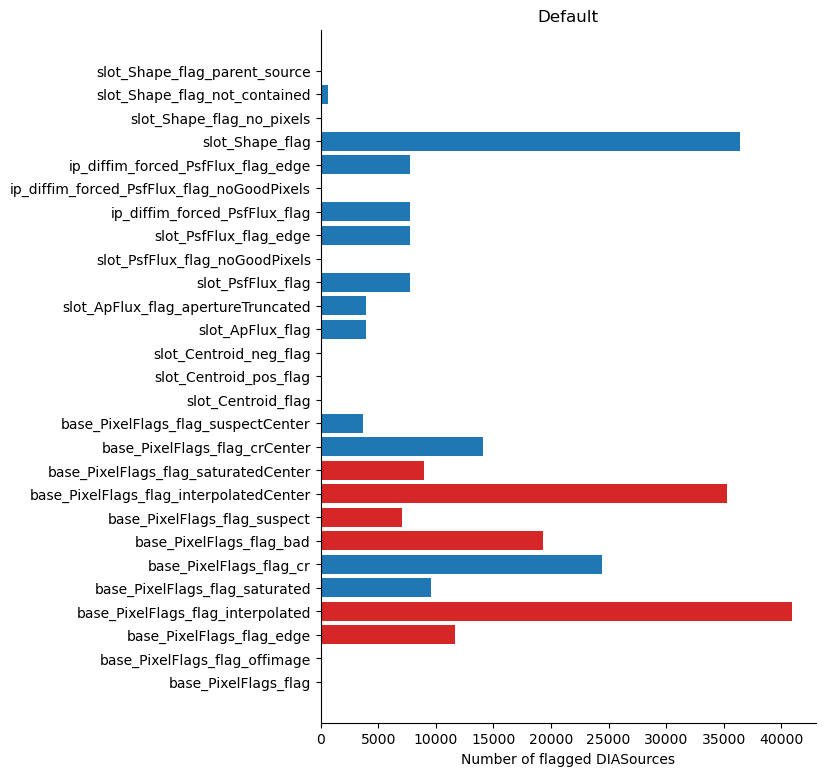

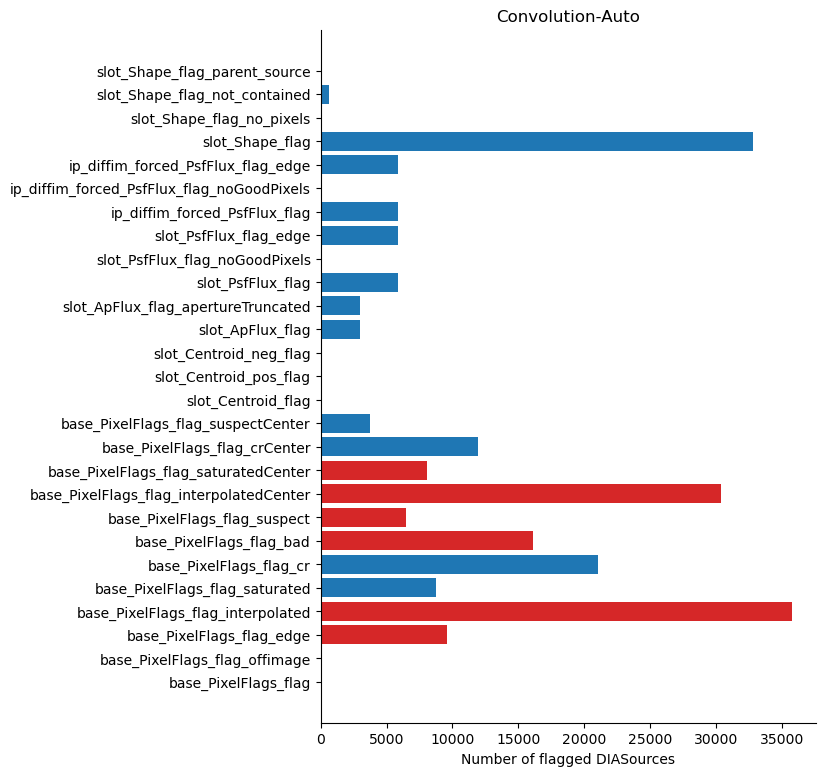

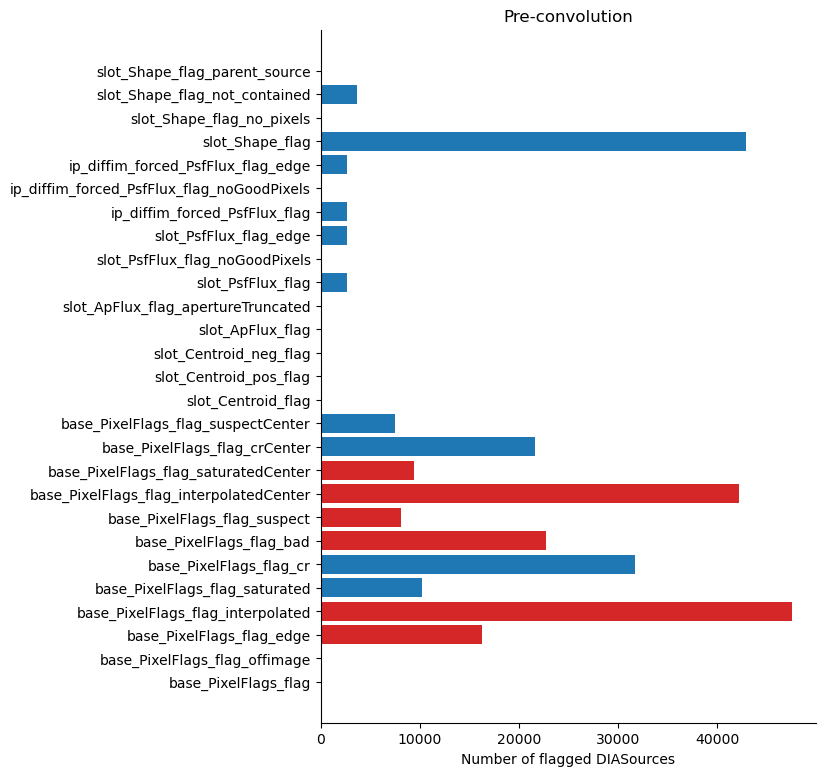

In [51]:
for arun in [default_run, automod_run, preconv_run]:
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    
    plac.plotFlagHist(srcTable, title=f'{arun["run_name"]}', badFlagList=badFlagList)

## B. Fake source analysis

### 8. Fake source analysis

In [52]:
tractList = [9813]

In [53]:
def collectMatchedDiaSources(fakesMatchDiaSrc, maxi=-1):
    """Given a butler query of fakesMatchDiaSrc datasetRefs, create a pandas dataframe with them all.
    'All' is defined as up to maxi of them, so it doesn't take forever.
    
    If you really want all of them, set maxi to -1.
    """
    #%%time
    visitDetectorFrames = []

    i = 0

    for datasetRef in fakesMatchDiaSrc: 
        try:
            frame = butler.getDirect(datasetRef)
            # nondetected sources don't have DIASource records--so propagate metadata to all rows
            # grab a detected row
            w = frame['diaSourceId'] > 0
            if np.sum(w) == 0:
                print(f'No real sources detected in {datasetRef}')
                continue
            ccdVisitId = int(frame.loc[w,'ccdVisitId'].iloc[0])
            filterName = frame.loc[w,'filterName'].iloc[0]
            # propagate to all rows
            frame.loc[:,'ccdVisitId'] = ccdVisitId 
            frame.loc[:,'filterName'] = filterName 
        except Exception as e:
            raise(e)
        else:
            visitDetectorFrames.append(frame)
        i+=1
        if i == maxi:
            break

    matchedDiaSources = pd.concat(visitDetectorFrames)

    matchedDiaSources.loc[:,'ra'] = np.degrees(matchedDiaSources['ra_x'])
    matchedDiaSources.loc[:,'decl'] = np.degrees(matchedDiaSources['dec'])

    return matchedDiaSources

In [54]:
for arun in [default_run, automod_run, preconv_run]:
    arun["dfs"] = [arun["butler"].get(
        'fakes_fakeSourceCat', collections=arun["collections"], instrument=arun["instrument"], skymap=arun["skymap"], tract=tract
    ) for tract in tractList]
    arun["allInjectedFakes"] = pd.concat(arun["dfs"], ignore_index=True)
    
    arun["fakesMatchDiaSrc"] = arun["butler"].registry.queryDatasets(collections=arun["collections"],
                                                 datasetType='fakes_goodSeeingDiff_matchDiaSrc')
    arun["matchedDiaSources"] = collectMatchedDiaSources(arun["fakesMatchDiaSrc"])
    
    instrumentDataId = butler.registry.expandDataId(instrument=instrument)
    packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
    dataId = packer.unpack(arun["matchedDiaSources"].ccdVisitId)
    arun["matchedDiaSources"]['visit'] = dataId['visit']
    arun["matchedDiaSources"]['detector'] = dataId['detector']

In [55]:
n_objs.loc['default', 'n_fakesMatched'] = len(default_run['matchedDiaSources'])
n_objs.loc['preconv', 'n_fakesMatched'] = len(preconv_run['matchedDiaSources'])
n_objs.loc['automod', 'n_fakesMatched'] = len(automod_run['matchedDiaSources'])

In [56]:
n_objs['n_FakesDiff'] = n_objs['n_diasrc'] - n_objs['n_fakesMatched']

In [57]:
n_objs

n_rdiasrc  n_rdiaobj  n_diasrc  n_diaobj  n_good_diaobj  \
default    54799.0    54799.0   54799.0   33974.0         6166.0   
preconv    60243.0    60243.0   60243.0   41343.0         6381.0   
automod    50049.0    50049.0   50049.0   30926.0         6698.0   

         n_good_diasrc  n_fakesMatched  n_FakesDiff  
default        13244.0          4627.0      50172.0  
preconv        10909.0          4594.0      55649.0  
automod        13727.0          4321.0      45728.0

### 9. Completeness as in previous notebooks

Adding also spatial distribution

In [58]:
def completenessByBandPlot(matchedDiaSources, bandList, colorList, flux_col_suffix='_mag', doRaDecCut=False):

    completeness_byband = {}
    completeness_err_byband = {}
    bins = np.linspace(20, 29, 30)
    
    # Some filters
    wScienceOnly = matchedDiaSources['isVisitSource'] & ~matchedDiaSources['isTemplateSource']
    wMatched = matchedDiaSources['diaSourceId'] > 0
    
    if doRaDecCut:
        # Spatial cut  # probably redundant now that we do RA/Dec cut in trimFakes
        minra = matchedDiaSources.loc[wScienceOnly & wMatched,'ra'].min()
        maxra = matchedDiaSources.loc[wScienceOnly & wMatched,'ra'].max()
        mindecl = matchedDiaSources.loc[wScienceOnly & wMatched,'decl'].min()
        maxdecl = matchedDiaSources.loc[wScienceOnly & wMatched,'decl'].max()
        wRADec = (matchedDiaSources.ra < maxra) & (matchedDiaSources.ra > minra) & \
                 (matchedDiaSources.decl > mindecl) & (matchedDiaSources.decl < maxdecl)

    for band in bandList:
        wband = matchedDiaSources['filterName'] == band

        if doRaDecCut:
            matched_filter = (wMatched & wScienceOnly & wRADec & wband)
            unmatched_filter = (~wMatched & wScienceOnly & wRADec & wband)
        else:
            matched_filter = (wMatched & wScienceOnly &  wband)
            unmatched_filter = (~wMatched & wScienceOnly & wband)

        n_matched, edges = np.histogram(matchedDiaSources.loc[matched_filter, f'{band}{flux_col_suffix}'], bins=bins)
        n_unmatched, edges = np.histogram(matchedDiaSources.loc[unmatched_filter, f'{band}{flux_col_suffix}'], bins=bins)

        ntot = n_matched + n_unmatched
        nmatched_err = np.sqrt(n_matched)
        completeness_byband[band] = n_matched/ntot

        # Attempt to compute some kind of error
        ntot_err = np.sqrt(ntot) # compute on total to keep Poisson errors in gaussian regime
        completeness_err_byband[band] = completeness_byband[band] * \
                                        np.sqrt((nmatched_err/n_matched)**2. + (ntot_err/ntot)**2.)
    
    plt.figure()
    plt.title('Spatial distribution of matched DIA Sources')
    plt.scatter(matchedDiaSources.loc[wScienceOnly & wMatched,'ra'], \
                matchedDiaSources.loc[wScienceOnly & wMatched,'decl'],
                marker='x', s=3, label='Matched science fake')
    plt.scatter(matchedDiaSources.loc[wScienceOnly & ~wMatched,'ra'], \
                matchedDiaSources.loc[wScienceOnly & ~wMatched,'decl'],
                marker='.', s=3, label='Unmatched science fake')
    plt.legend()
    
    if len(bandList) > 1:
        fig, axs = plt.subplots(1, 2, figsize=(9, 4))
        axG = axs[0]
        axR = axs[1]
        
        #axHits = axs[2, 1]
        #ax0 = axs[1]
        #ax0.axis('off')
        axList = [axG, axR] #, axI, axZ, axY]
        colorList = ['C2', 'C1'] #, 'C3', 'C5', 'k']
        xlim = (20,28)
        ylim = (0, 1)
        plt.setp(axs, xlim=xlim, ylim=ylim)
        fig.suptitle(f'Completeness')
        for ax, band, color in zip(axList, bandList, colorList):
            ax.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color)
    
    plt.figure(figsize=(8, 6))
    for band, color in zip(bandList, colorList):
        plt.errorbar(bins[0:-1], completeness_byband[band], completeness_err_byband[band], color=color, label=band)
    plt.axhline(.9, ls='--', color='0.75')#, label='90%')
    plt.legend(loc='lower left')
    plt.xlabel('Injected magnitude')
    plt.ylabel('Fractional completeness')
    plt.title('Completeness for sources injected into science (visit) images')

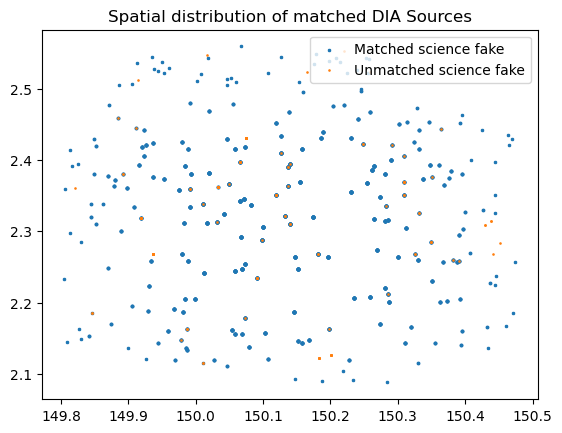

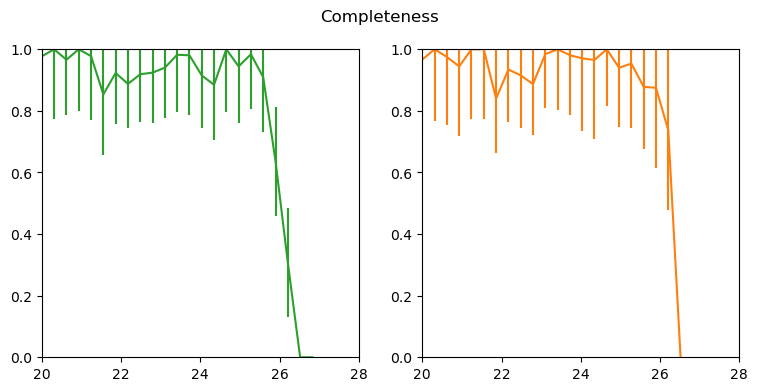

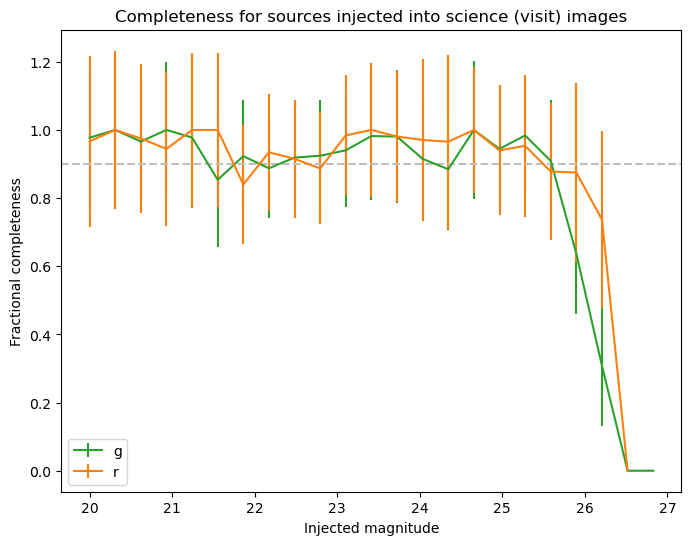

In [59]:
completenessByBandPlot(default_run['matchedDiaSources'], bandList, colorList,
                       flux_col_suffix='_mag', doRaDecCut=False)

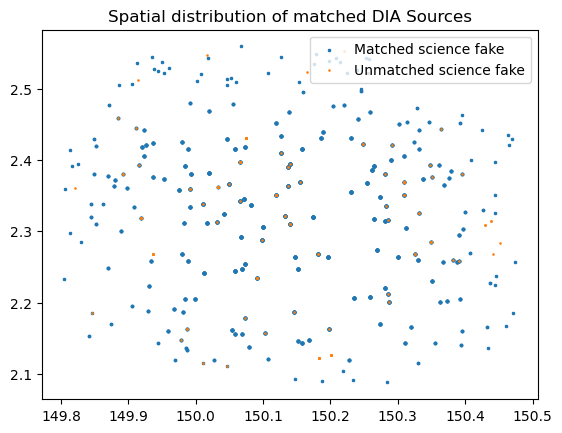

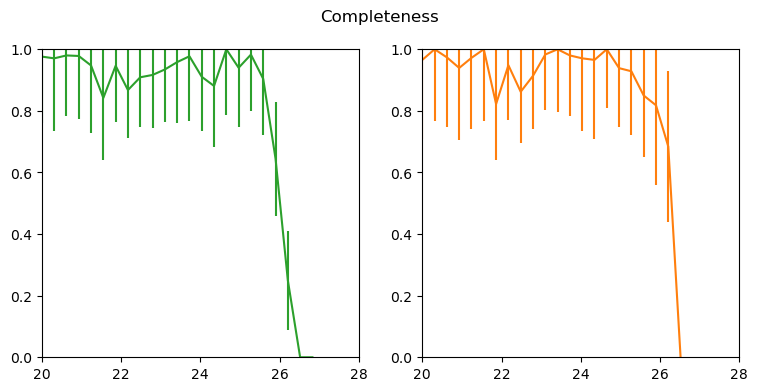

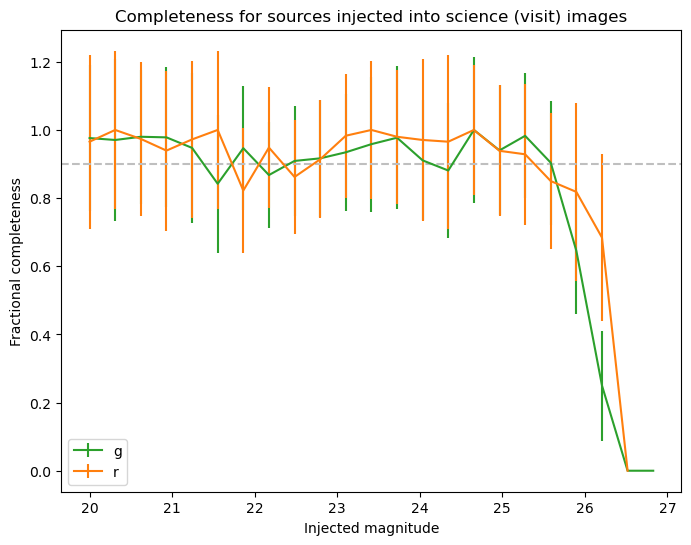

In [60]:
completenessByBandPlot(automod_run['matchedDiaSources'], bandList, colorList,
                       flux_col_suffix='_mag', doRaDecCut=False)

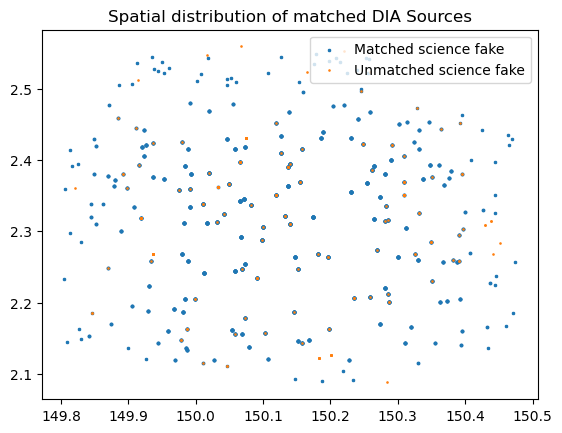

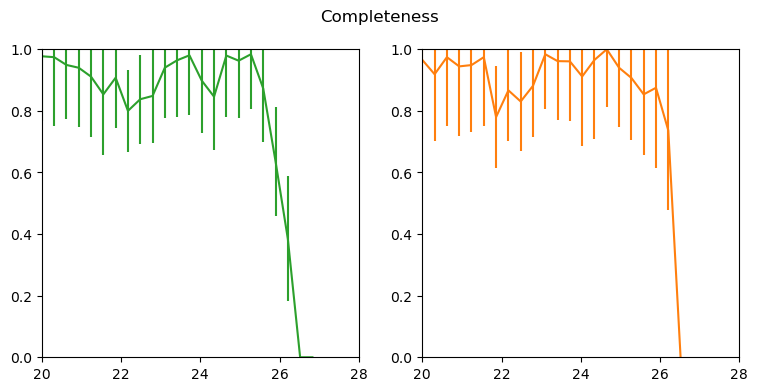

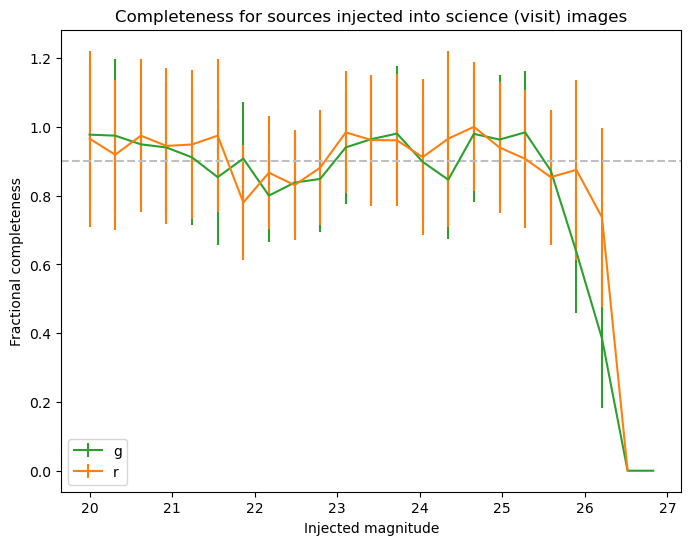

In [61]:
completenessByBandPlot(preconv_run['matchedDiaSources'], bandList, colorList,
                       flux_col_suffix='_mag', doRaDecCut=False)

Completeness marginally decreases for automod and again for pre-convolution

### 10. Image eyeballing

In [62]:
visits = [11690]
detectors = [49]

Collection:  u/bos/DM-37957/w_2023_07_default , Visit:  11690 , Detector:  49


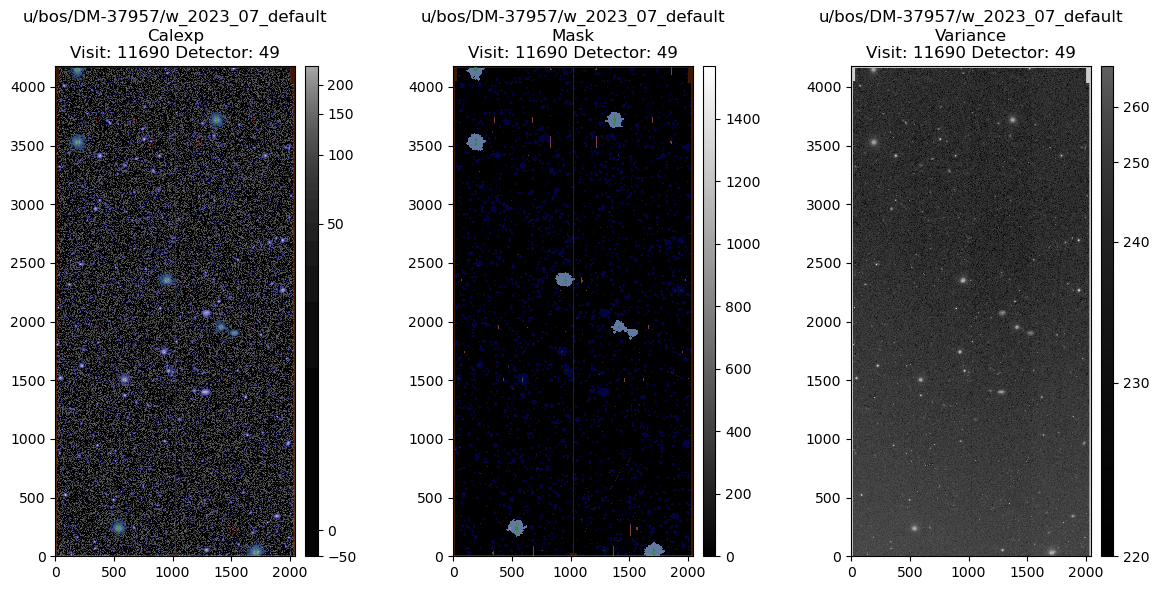

In [63]:
collection = default_run['collections']
butler = default_run['butler']

for visit in visits:
    for detector in detectors:
        print('Collection: ', collection,
              ', Visit: ', visit,
              ', Detector: ', detector)
        afwDisplay.setDefaultBackend('matplotlib') 

        calexp = butler.get('calexp', instrument='HSC',
                            visit=visit, detector=detector, collections=collection)
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))

        plt.sca(ax1)  # set the first axis as current
        display1 = afwDisplay.Display(frame=fig)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')

        plt.sca(ax2)  # set the second axis as current
        display2 = afwDisplay.Display(frame=fig)
        display2.mtv(calexp.mask, f'{collection}\nMask\nVisit: {visit} Detector: {detector}')

        plt.sca(ax3) # set the third axis as current
        display3 = afwDisplay.Display(frame=fig)
        display3.scale('asinh', 'zscale')
        display3.mtv(calexp.variance, f'{collection}\nVariance\nVisit: {visit} Detector: {detector}')

        plt.tight_layout()
        plt.show()
        plt.close(fig)

Collection:  u/bos/DM-37957/w_2023_07_default , Visit:  11690 , Detector:  49
Accepted PSF Sources (green):  52  Rejected PSF Sources (red):  17


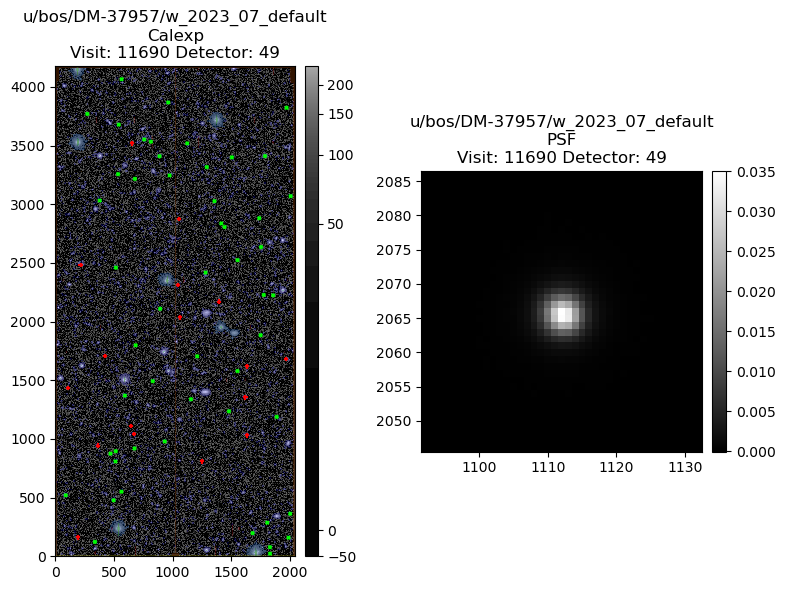

In [64]:
for visit in visits:
    for detector in detectors:
        print('Collection: ', collection,
              ', Visit: ', calexp.visitInfo.getId(),
              ', Detector: ', calexp.detector.getId())

        afwDisplay.setDefaultBackend('matplotlib') 
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 6))

        plt.sca(ax1)  # set the first axis as current
        calexp = butler.get('calexp', instrument=instrument,
                            visit=visit, detector=detector, collections=collection)
        display1 = afwDisplay.Display(frame=fig)
        display1.setMaskTransparency(80)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')
        src = butler.get('src', instrument=instrument,
                         visit=visit, detector=detector, collections=collection)
        acceptedPsfSources = src[src['calib_psf_used']]
        rejectedPsfSources = src[src['calib_psf_candidate'] &
                             (src['calib_psf_used'] == False)]
        print('Accepted PSF Sources (green): ', len(acceptedPsfSources),
              ' Rejected PSF Sources (red): ', len(rejectedPsfSources))
        with display1.Buffering():
            for s in src[src['calib_psf_used']]:
                display1.dot("x", s.getX(), s.getY(), size=10, ctype='green')
        with display1.Buffering():
            for s in rejectedPsfSources:
                display1.dot("+", s.getX(), s.getY(), size=10, ctype='red')

        plt.sca(ax2)  # set the second axis as current
        psf = calexp.getPsf()
        position = psf.getAveragePosition()
        display2 = afwDisplay.Display(frame=fig)
        display2.mtv(psf.computeImage(position), f'{collection}\nPSF\nVisit: {visit} Detector: {detector}')

        plt.tight_layout()
        plt.show()
        plt.close(fig)

Collection:  u/bos/DM-38186/w_2023_07_automode , Visit:  11690 , Detector:  49


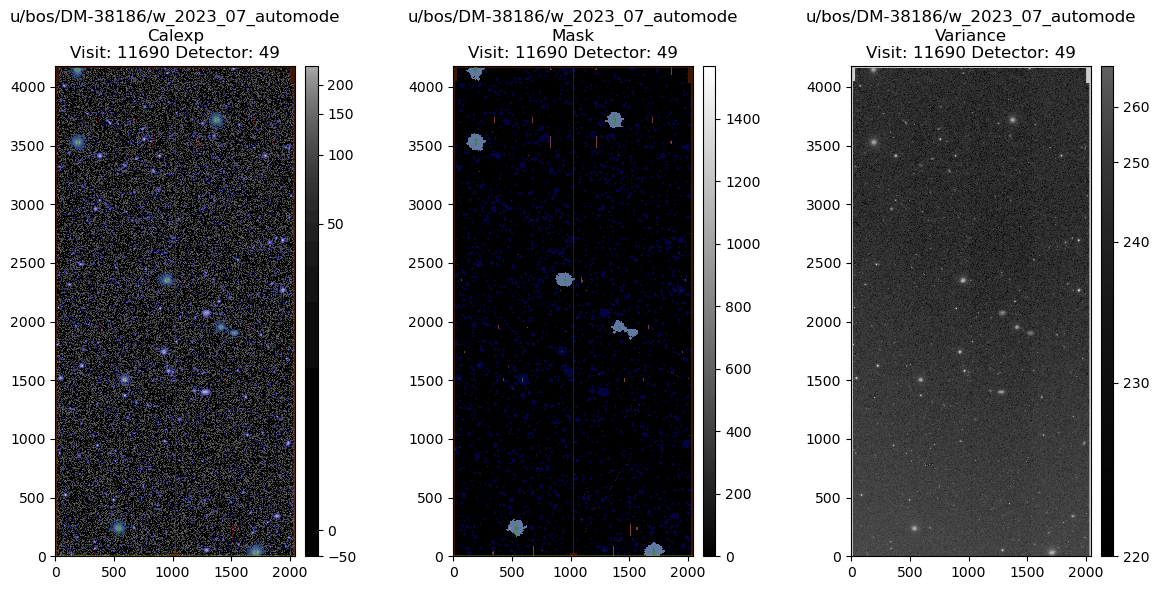

In [65]:
collection = automod_run['collections']
butler = automod_run['butler']

for visit in visits:
    for detector in detectors:
        print('Collection: ', collection,
              ', Visit: ', visit,
              ', Detector: ', detector)
        afwDisplay.setDefaultBackend('matplotlib') 

        calexp = butler.get('calexp', instrument='HSC',
                            visit=visit, detector=detector, collections=collection)
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))

        plt.sca(ax1)  # set the first axis as current
        display1 = afwDisplay.Display(frame=fig)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')

        plt.sca(ax2)  # set the second axis as current
        display2 = afwDisplay.Display(frame=fig)
        display2.mtv(calexp.mask, f'{collection}\nMask\nVisit: {visit} Detector: {detector}')

        plt.sca(ax3) # set the third axis as current
        display3 = afwDisplay.Display(frame=fig)
        display3.scale('asinh', 'zscale')
        display3.mtv(calexp.variance, f'{collection}\nVariance\nVisit: {visit} Detector: {detector}')

        plt.tight_layout()
        plt.show()
        plt.close(fig)

Collection:  u/bos/DM-38186/w_2023_07_automode , Visit:  11690 , Detector:  49
Accepted PSF Sources (green):  52  Rejected PSF Sources (red):  17


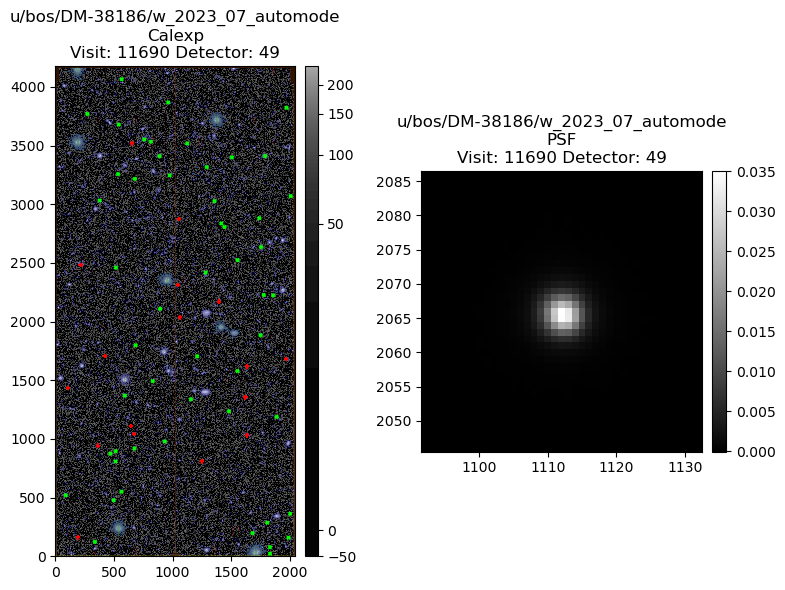

In [66]:
for visit in visits:
    for detector in detectors:
        print('Collection: ', collection,
              ', Visit: ', calexp.visitInfo.getId(),
              ', Detector: ', calexp.detector.getId())

        afwDisplay.setDefaultBackend('matplotlib') 
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 6))

        plt.sca(ax1)  # set the first axis as current
        calexp = butler.get('calexp', instrument=instrument,
                            visit=visit, detector=detector, collections=collection)
        display1 = afwDisplay.Display(frame=fig)
        display1.setMaskTransparency(80)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')
        src = butler.get('src', instrument=instrument,
                         visit=visit, detector=detector, collections=collection)
        acceptedPsfSources = src[src['calib_psf_used']]
        rejectedPsfSources = src[src['calib_psf_candidate'] &
                             (src['calib_psf_used'] == False)]
        print('Accepted PSF Sources (green): ', len(acceptedPsfSources),
              ' Rejected PSF Sources (red): ', len(rejectedPsfSources))
        with display1.Buffering():
            for s in src[src['calib_psf_used']]:
                display1.dot("x", s.getX(), s.getY(), size=10, ctype='green')
        with display1.Buffering():
            for s in rejectedPsfSources:
                display1.dot("+", s.getX(), s.getY(), size=10, ctype='red')

        plt.sca(ax2)  # set the second axis as current
        psf = calexp.getPsf()
        position = psf.getAveragePosition()
        display2 = afwDisplay.Display(frame=fig)
        display2.mtv(psf.computeImage(position), f'{collection}\nPSF\nVisit: {visit} Detector: {detector}')

        plt.tight_layout()
        plt.show()
        plt.close(fig)

Collection:  u/bos/DM-37959-HTCondor-preconv , Visit:  11690 , Detector:  49


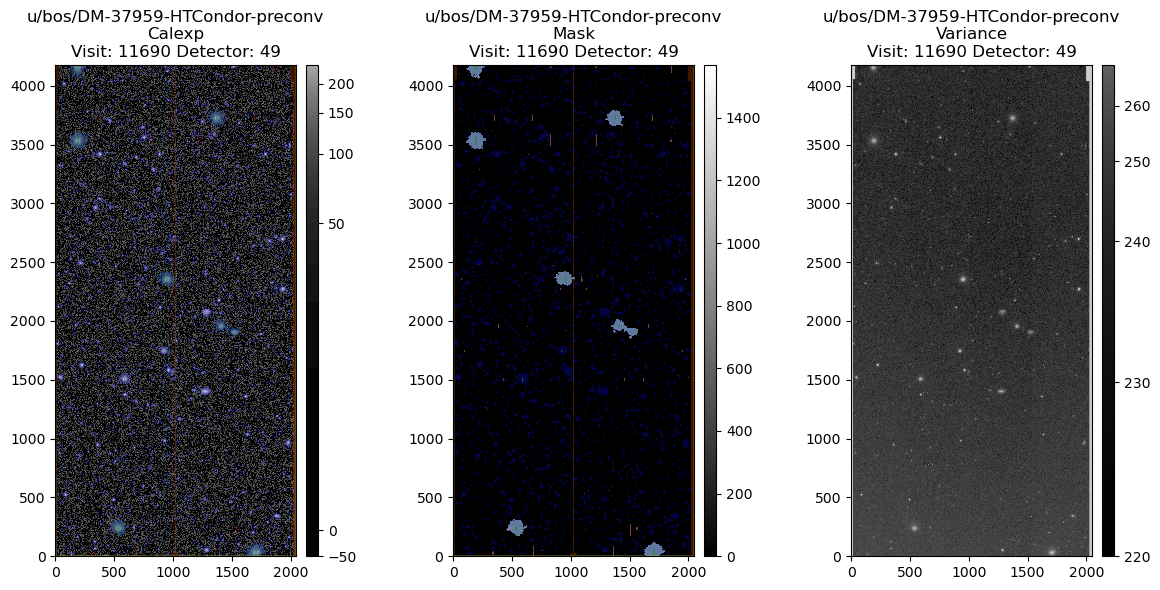

In [67]:
collection = preconv_run['collections']
butler = preconv_run['butler']

for visit in visits:
    for detector in detectors:
        print('Collection: ', collection,
              ', Visit: ', visit,
              ', Detector: ', detector)
        afwDisplay.setDefaultBackend('matplotlib') 

        calexp = butler.get('calexp', instrument='HSC',
                            visit=visit, detector=detector, collections=collection)
        fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(12, 6))

        plt.sca(ax1)  # set the first axis as current
        display1 = afwDisplay.Display(frame=fig)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')

        plt.sca(ax2)  # set the second axis as current
        display2 = afwDisplay.Display(frame=fig)
        display2.mtv(calexp.mask, f'{collection}\nMask\nVisit: {visit} Detector: {detector}')

        plt.sca(ax3) # set the third axis as current
        display3 = afwDisplay.Display(frame=fig)
        display3.scale('asinh', 'zscale')
        display3.mtv(calexp.variance, f'{collection}\nVariance\nVisit: {visit} Detector: {detector}')

        plt.tight_layout()
        plt.show()
        plt.close(fig)

Collection:  u/bos/DM-37959-HTCondor-preconv , Visit:  11690 , Detector:  49
Accepted PSF Sources (green):  52  Rejected PSF Sources (red):  17


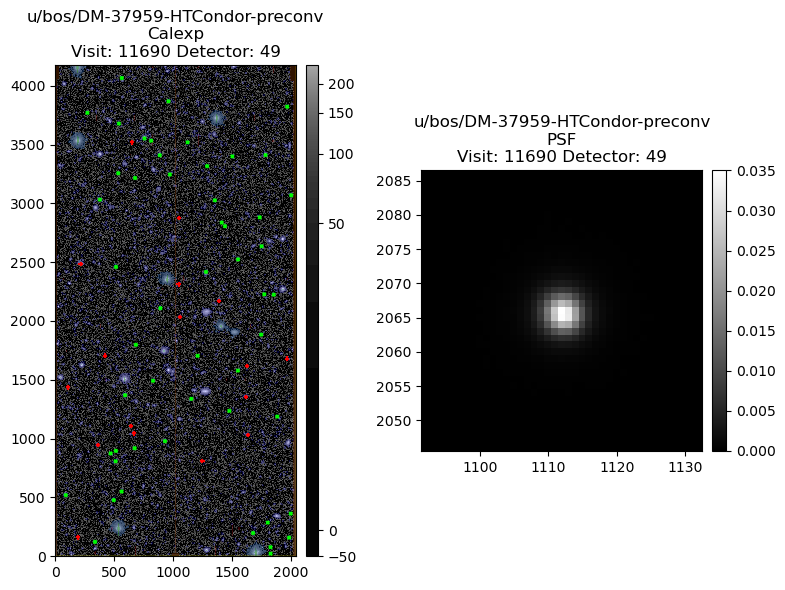

In [68]:
for visit in visits:
    for detector in detectors:
        print('Collection: ', collection,
              ', Visit: ', calexp.visitInfo.getId(),
              ', Detector: ', calexp.detector.getId())

        afwDisplay.setDefaultBackend('matplotlib') 
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 6))

        plt.sca(ax1)  # set the first axis as current
        calexp = butler.get('calexp', instrument=instrument,
                            visit=visit, detector=detector, collections=collection)
        display1 = afwDisplay.Display(frame=fig)
        display1.setMaskTransparency(80)
        display1.scale('asinh', -1, 30)
        display1.mtv(calexp, f'{collection}\nCalexp\nVisit: {visit} Detector: {detector}')
        src = butler.get('src', instrument=instrument,
                         visit=visit, detector=detector, collections=collection)
        acceptedPsfSources = src[src['calib_psf_used']]
        rejectedPsfSources = src[src['calib_psf_candidate'] &
                             (src['calib_psf_used'] == False)]
        print('Accepted PSF Sources (green): ', len(acceptedPsfSources),
              ' Rejected PSF Sources (red): ', len(rejectedPsfSources))
        with display1.Buffering():
            for s in src[src['calib_psf_used']]:
                display1.dot("x", s.getX(), s.getY(), size=10, ctype='green')
        with display1.Buffering():
            for s in rejectedPsfSources:
                display1.dot("+", s.getX(), s.getY(), size=10, ctype='red')

        plt.sca(ax2)  # set the second axis as current
        psf = calexp.getPsf()
        position = psf.getAveragePosition()
        display2 = afwDisplay.Display(frame=fig)
        display2.mtv(psf.computeImage(position), f'{collection}\nPSF\nVisit: {visit} Detector: {detector}')

        plt.tight_layout()
        plt.show()
        plt.close(fig)

### 11. SNR of detections

Now we would like to work on SNR, 
and probably calculate efficiency vs SNR

In [69]:
from lsst.geom import Point2D

In [70]:
from astropy.stats import sigma_clipped_stats

In [71]:
for arun in [default_run, automod_run, preconv_run]:
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    matchedDiaSources = arun['matchedDiaSources']
    butler = arun['butler']

    fakeids = []
    instfluxes = []
    instfluxerrs = []
    psf_eqNAs = []
    rel_errs = []
    failediter = False
    for avisit, subtable in matchedDiaSources.groupby('visit'):
        for det, agroup in subtable.groupby('detector'):
            dif = butler.get('fakes_goodSeeingDiff_differenceExp', visit=int(avisit), detector=int(det), instrument='HSC')
            dif_info = dif.getInfo().getVisitInfo()
            dif_pcal = dif.getPhotoCalib()
            dif_psf = dif.getPsf()
            dif_wcs = dif.getWcs()
            dif_box = dif.getBBox()
            dif_var = dif.getVariance()
            cal_err = dif_pcal.getCalibrationErr()
            #mean_var, median_var, std_var = sigma_clipped_stats(dif_var.array)

            for i_row, arow in agroup.iterrows():
                pxy = Point2D(arow.x_x, arow.y_x)
                mean_var, median_var, std_var = sigma_clipped_stats(
                    dif_var.array[
                        np.max([np.int(arow.y_x) - 20, 0]): np.min([4176, np.int(arow.y_x)+20]),
                        np.max([np.int(arow.x_x) - 20, 0]): np.min([4176, np.int(arow.x_x)+20]) 
                    ]
                )
                # bear in mind that the magnitude of template fake is negative
                delta_mag = arow[f'{arow.filterName}_mag']
                if delta_mag < 0 :
                    delta_mag = np.abs(delta_mag)

                true_flux_njy = (delta_mag*u.ABmag).to(u.nanojansky).value

                instflux = dif_pcal.magnitudeToInstFlux(delta_mag, pxy)
                rel_err = (instflux**2) * (cal_err/true_flux_njy)

                psf_eqNA = 1./np.sum(np.square(dif_psf.computeImage(pxy).array))
                skynoise = psf_eqNA * median_var

                instflux_err = np.sqrt(instflux + skynoise + rel_err**2)
                calc_snr = instflux / instflux_err


                wfakeid = matchedDiaSources.fakeId==arow.fakeId
                matchedDiaSources.loc[wfakeid, 'mean_var'] = mean_var
                matchedDiaSources.loc[wfakeid, 'median_var'] = median_var
                matchedDiaSources.loc[wfakeid, 'std_var'] = std_var
                matchedDiaSources.loc[wfakeid, 'delta_mag'] = delta_mag
                matchedDiaSources.loc[wfakeid, 'calc_true_flux_njy'] = true_flux_njy
                matchedDiaSources.loc[wfakeid, 'calc_instflux'] = instflux
                matchedDiaSources.loc[wfakeid, 'calc_instflux_err'] = instflux_err
                matchedDiaSources.loc[wfakeid, 'calc_psf_eqNA'] = psf_eqNA
                matchedDiaSources.loc[wfakeid, 'calc_skynoise'] = skynoise
                matchedDiaSources.loc[wfakeid, 'calc_snr'] = calc_snr

            if failediter:
                break
        if failediter:
            break
    matchedDiaSources['flagged'] = ~matchedDiaSources.diaSourceId.isin(goodSrc.diaSourceId)
    matchedDiaSources['psFluxSNR'] = matchedDiaSources.psFlux / matchedDiaSources.psFluxErr
    matchedDiaSources['totFluxSNR'] = matchedDiaSources.totFlux / matchedDiaSources.totFluxErr
    matchedDiaSources['matched'] = matchedDiaSources['diaSourceId']>0
    matchedDiaSources['estimated_SN_ratio'] = matchedDiaSources['calc_snr']
    
    arun['found'] = matchedDiaSources[matchedDiaSources.diaSourceId>0]
    

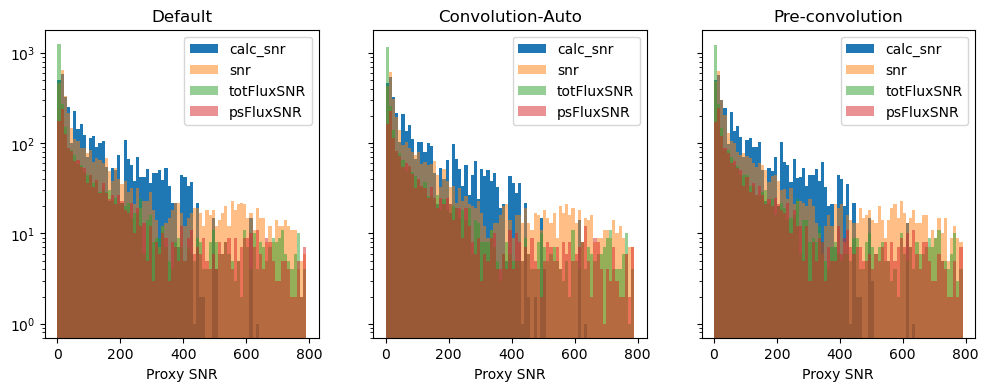

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    matchedDiaSources = arun['matchedDiaSources']
    butler = arun['butler']
    
    found = arun['found']
    
    ax = axes.flatten()[i_run]
    ax.hist(found.calc_snr, bins=np.arange(0, 800, 10), log=True, label='calc_snr')
    ax.hist(found.snr, alpha=0.5, bins=np.arange(0, 800, 10), label='snr')
    ax.hist(found.totFluxSNR, alpha=0.5, bins=np.arange(0, 800, 10), label='totFluxSNR')
    ax.hist(found.psFluxSNR, alpha=0.5, bins=np.arange(0, 800, 10), label='psFluxSNR')
    ax.set_xlabel('Proxy SNR')
    ax.legend(loc='upper right')
    ax.set_title(arun['run_name'])

### 12. SNR Modeled vs Fake magnitude

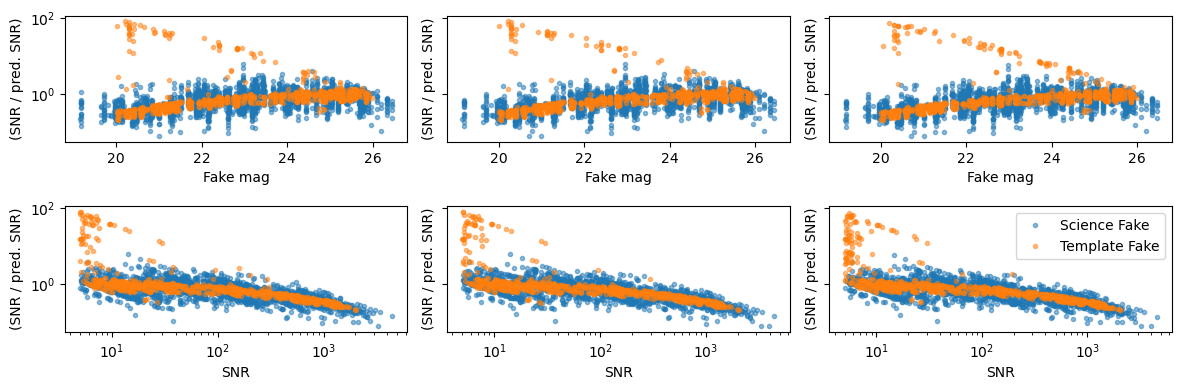

In [73]:
fig, axes = plt.subplots(2, 3, figsize=(12, 4), sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    matchedDiaSources = arun['matchedDiaSources']
    butler = arun['butler']
    
    found = arun['found']
    
    ax1 = axes[0, i_run]
    ax2 = axes[1, i_run]

    #fig, (ax1, ax2) = plt.subplots(2, 1)
    for adet, agroup in found[found.totFluxSNR>0.5].groupby('isTemplateSource'):
        lab = 'Template Fake' if adet else 'Science Fake'
        ax1.plot(agroup.delta_mag, agroup.calc_snr/agroup.snr, '.', label=lab, alpha=0.5)
        ax1.set_yscale('symlog')
        ax1.set_xlabel('Fake mag')
        ax1.set_ylabel('(SNR / pred. SNR)')
        
        ax2.loglog(agroup.snr, agroup.calc_snr/agroup.snr, '.', label=lab, alpha=0.5)
        #ax2.set_scale('symlog')
        ax2.set_xlabel('SNR')
        ax2.set_ylabel('(SNR / pred. SNR)')
    plt.legend(loc='best')
plt.tight_layout()

### 13. Efficiency estimation

In [74]:
from scipy.optimize import curve_fit

In [75]:
def power_law(x, k, a):
    """General power law model"""
    return k*(x**a) #+ b

def fsigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(-a*(x-b)))

def sigmoid(x, a, b):
    return 1.0 / (1.0 + np.exp(a*(x-b)))

def half_gaussian(x, sig, ampl, k):
    me = 0
    return ampl/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-me)/sig)**2)

def gaussian(x, sig, me, ampl):
    return ampl/(sig*np.sqrt(2*np.pi)) * np.exp(-0.5*((x-me)/sig)**2)

In [76]:
def estimate_effcurve(df, wid=0.5, bins=None):
    if bins is None:
        bins = np.arange(0, 50, wid)
    redges = bins[:-1] #+ wid/2.
    center = bins[:-1] + wid/2.

    counts, mbins = np.histogram(df.estimated_SN_ratio, bins=bins)
    mcount, mbins = np.histogram(df[df.matched==True].estimated_SN_ratio, bins=bins)

    eff = mcount/counts
    eff[np.where(counts==0.)] = 0.
    err = 1.96*np.sqrt(eff*(1-eff)/counts)
    err[np.where(counts==0.)] = 1
    err[np.where(err==0)] = 0.05

    popt, pcov = curve_fit(fsigmoid, center, eff, sigma=err, method='dogbox') #, bounds=([0., 5.], [-20., -26.])
    eff_12 = np.round(popt[1], 2)

    hi_err = err.copy()
    hi_err[np.where((hi_err+eff)>=1)] = (1 - eff)[np.where((hi_err+eff)>=1)]
    yerr = [err, hi_err]
    return {
        'center': center,
        'fsigmoid': fsigmoid(center, popt[0], popt[1]),
        'redges': redges,
        'eff': eff,
        'eff_12': eff_12,
        'popt': popt,
        'pcov': pcov,
        'counts': counts,
        'mcounts': mcount,
        'bins': bins,
        'yerr': yerr,
        'hi_err': hi_err,
        'err': err,
        'mbins': mbins,
    }

In [77]:
import matplotlib
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [78]:
def plot_recall(df, ax=None, wid=0.5, bins=None):
    if bins is not None:
        bins = np.arange(0, 18, wid)
    results = estimate_effcurve(df, wid=wid, bins=bins)

    center = results['center']
    fsigmd = results['fsigmoid']
    redges = results['redges']
    eff = results['eff']
    eff_12 = results['eff_12']
    popt = results['popt']
    pcov = results['pcov']
    counts = results['counts']
    mcounts = results['mcounts']
    bins = results['bins']
    yerr = results['yerr']
    hi_err = results['hi_err']
    err = results['err']


    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 4), nrows=1, ncols=1 )
    #ax.plot(center, fsigmoid(center, popt[0], popt[1]), 'k-', label='Sigmoid fit', alpha=0.7)
    ax.plot(center, fsigmd, 'k-', label='Sigmoid fit', alpha=0.7)
    ax.step(redges, eff, 'k', where='post', lw=1.5)#, label='No band')

    ax.errorbar(redges+wid/2., eff, yerr=yerr, fmt='k.')
    ax.axhline(y=0.5, xmin=0.05, xmax=0.95, color='gray', ls='-', lw=0.9)
    ax.axvline(x=eff_12, ymin=0, ymax=1., ls='--', label=r'$\rm{SNR}_{1/2} = $'+str(eff_12), color='k')
    patches = []
    print(np.min(counts), np.max(counts))
    #norm = colors.Normalize(counts.min(), counts.max())
    norm = colors.LogNorm(vmin=counts.min()+1, vmax=counts.max())
    for abin, aneff, co in zip(redges, eff, counts):
        patch = Rectangle((abin, 0.), wid, aneff)
        patches.append(patch)
    pcolors = norm(counts)
    pcolors[np.where(counts==0.)] = -1.

    #ax.grid()
    collection = PatchCollection(patches, cmap=plt.cm.gray, alpha=0.7)
    collection.set_array(pcolors)
    ax.add_collection(collection)

    ax.set_ylim(0, 1.1)
    ax.set_xlim(0, 16)
    ax.set_xlabel('Estimated truth SNR')
    ax.set_ylabel('Efficiency $\%$')
    ax.set_xticks([2., 3., 4.,  5., 6., 7., 8., 10., 15.])
    ax.yaxis.set_major_formatter(PercentFormatter(xmax=1))
    ax.legend(loc='lower right')
    plt.colorbar(collection, ax=ax, label=r'$log_{10}(N)$') #label='$N$')
    plt.tight_layout()
    plt.grid()
    return ax

In [79]:
for i_run, arun in enumerate([default_run, automod_run, preconv_run]):

    matchedDiaSources = arun['matchedDiaSources']

    matchedDiaSources['psf_mag'] = (matchedDiaSources.psFlux.values*u.nanojansky).to(u.ABmag).value
    matchedDiaSources['ap_mag'] = (matchedDiaSources.apFlux.values*u.nanojansky).to(u.ABmag).value
    matchedDiaSources['matched_not_flagged'] = matchedDiaSources['matched'] & (~matchedDiaSources['flagged'])
    arun['pulls'] = (matchedDiaSources.psFlux - matchedDiaSources.calc_true_flux_njy)/matchedDiaSources.psFluxErr

0 111
0 108
0 110


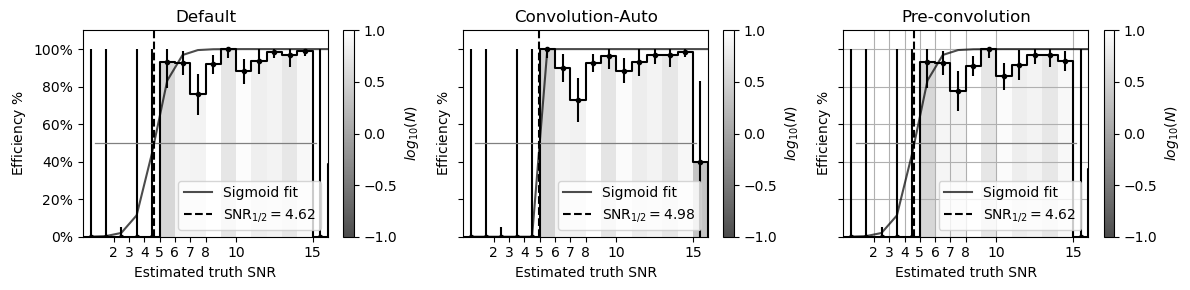

In [80]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    matchedDiaSources = arun['matchedDiaSources']
    butler = arun['butler']
    
    found = arun['found']
    
    ax = axes.flatten()[i_run]
    plot_recall(matchedDiaSources[matchedDiaSources.isTemplateSource], wid=1., ax=ax)
    ax.set_title(arun['run_name'])

### 14. Pulls and outliers 

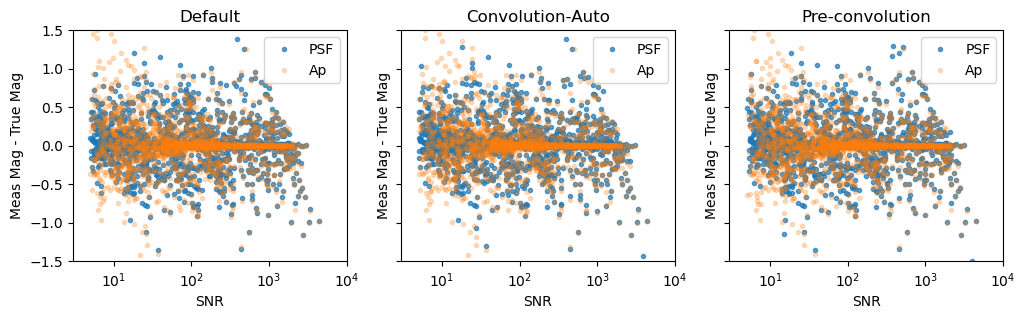

In [81]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    matchedDiaSources = arun['matchedDiaSources']
    
    ax = axes.flatten()[i_run]
    ax.plot(matchedDiaSources.snr, matchedDiaSources.psf_mag - matchedDiaSources.g_mag, '.', label='PSF', alpha=0.7)
    ax.plot(matchedDiaSources.snr, matchedDiaSources.ap_mag - matchedDiaSources.g_mag, '.', label='Ap', alpha=0.25)
    ax.set_ylim(-1.5, 1.5)
    ax.set_xlim(3, 1e4)
    ax.set_xscale('symlog')
    ax.set_xlabel('SNR')
    ax.set_ylabel('Meas Mag - True Mag')
    ax.legend(loc='best')
    ax.set_title(arun['run_name'])
    

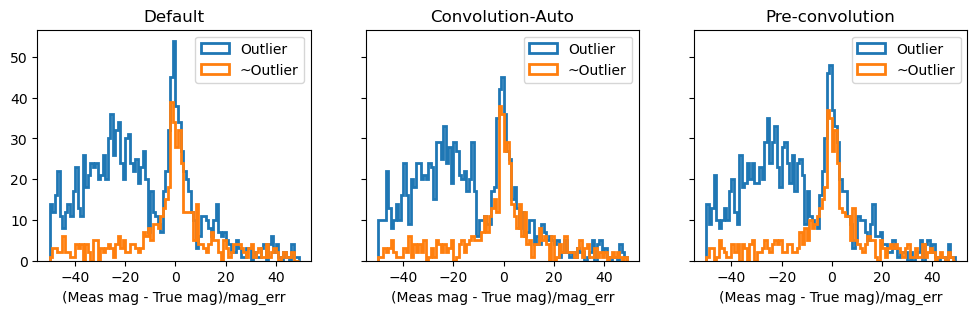

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    goodSrc = arun['goodSrc']
    collections = arun['collections']
    srcTable = arun['srcTable']
    matchedDiaSources = arun['matchedDiaSources']
    pulls = arun['pulls']
    
    ax = axes.flatten()[i_run]

    outliers = np.abs(matchedDiaSources.psf_mag - matchedDiaSources.g_mag) > 0.1
    outliers = outliers & (np.abs(matchedDiaSources.psFluxSNR) > 0.5)
    ax.hist(pulls[~outliers], bins=np.arange(-50, 50, 1), label='Outlier', histtype='step', lw=2)
    ax.hist(pulls[outliers], bins=np.arange(-50, 50, 1), label='~Outlier', histtype='step', lw=2)
    #plt.xlim(-10, 10)
    ax.set_xlabel('(Meas mag - True mag)/mag_err')
    ax.legend(loc='best')
    ax.set_title(arun['run_name'])

### 15. Check the flagged sources 

In [83]:
n_objs.loc['default', 'n_fakesMatched_not_flagged'] = np.sum(default_run['matchedDiaSources']['matched_not_flagged'])
n_objs.loc['preconv', 'n_fakesMatched_not_flagged'] = np.sum(preconv_run['matchedDiaSources']['matched_not_flagged'])
n_objs.loc['automod', 'n_fakesMatched_not_flagged'] = np.sum(automod_run['matchedDiaSources']['matched_not_flagged'])

In [84]:
n_objs

n_rdiasrc  n_rdiaobj  n_diasrc  n_diaobj  n_good_diaobj  \
default    54799.0    54799.0   54799.0   33974.0         6166.0   
preconv    60243.0    60243.0   60243.0   41343.0         6381.0   
automod    50049.0    50049.0   50049.0   30926.0         6698.0   

         n_good_diasrc  n_fakesMatched  n_FakesDiff  \
default        13244.0          4627.0      50172.0   
preconv        10909.0          4594.0      55649.0   
automod        13727.0          4321.0      45728.0   

         n_fakesMatched_not_flagged  
default                      2391.0  
preconv                      1732.0  
automod                      2348.0

## C. Analysis on the sensor

### 16. CCD Illumination
Let's check the CCD chip illumination. Main question is if the diaSources can be anywhere or they are biased and fall in some places in the CCD with more frequency.

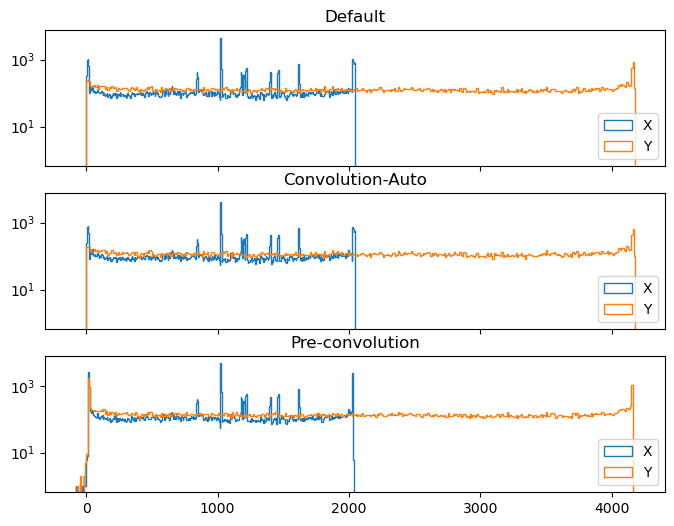

<Figure size 640x480 with 0 Axes>

In [85]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTable = arun['srcTable']
    pulls = arun['pulls']
    
    ax = axes.flatten()[i_run]

    ax.hist(srcTable.x, histtype='step', log=True, bins=np.arange(-100, 2100, 5), label='X')
    ax.hist(srcTable.y, histtype='step', bins=np.arange(-100, 4200, 10), label='Y')

    #plt.xlim(3950, 4130)
    ax.set_title(arun['run_name'])
    ax.legend(loc='lower right', fontsize=10)
plt.show()
plt.tight_layout()

Here we look at the same distribution, but now cutting on convetional flags (goodSrc)

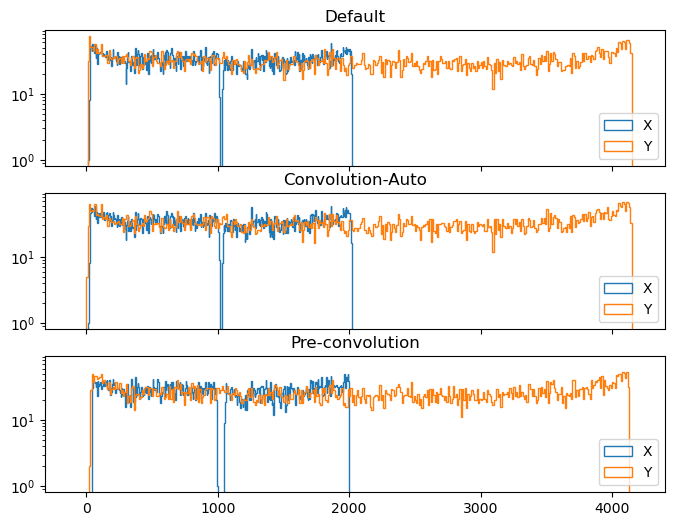

<Figure size 640x480 with 0 Axes>

In [86]:
fig, axes = plt.subplots(3, 1, figsize=(8, 6), sharex=True, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTable = arun['srcTable']
    goodSrc = arun['goodSrc']
    pulls = arun['pulls']
    
    ax = axes.flatten()[i_run]

    ax.hist(goodSrc.x, histtype='step', log=True, bins=np.arange(-100, 2100, 5), label='X')
    ax.hist(goodSrc.y, histtype='step', bins=np.arange(-100, 4200, 10), label='Y')

    #plt.xlim(3950, 4130)
    ax.set_title(arun['run_name'])
    ax.legend(loc='lower right', fontsize=10)
plt.show()
plt.tight_layout()

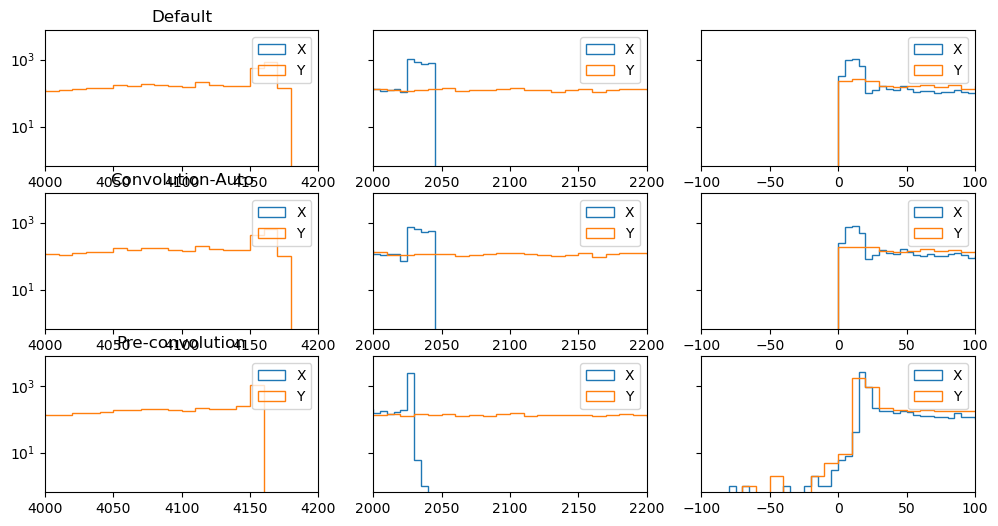

<Figure size 640x480 with 0 Axes>

In [87]:
fig, axes = plt.subplots(3, 3, figsize=(12, 6), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTable = arun['srcTable']
    pulls = arun['pulls']
    
    ax1 = axes[i_run, 0]
    ax1.hist(srcTable.x, histtype='step', log=True, bins=np.arange(-100, 2100, 5), label='X')
    ax1.hist(srcTable.y, histtype='step', bins=np.arange(-100, 4200, 10), label='Y')
    ax1.set_xlim(4000, 4200)
    ax1.legend(loc='best')
    ax1.set_title(arun['run_name'])

    ax2 = axes[i_run, 1]
    ax2.hist(srcTable.x, histtype='step', log=True, bins=np.arange(-100, 2100, 5), label='X')
    ax2.hist(srcTable.y, histtype='step', bins=np.arange(-100, 4200, 10), label='Y')
    ax2.set_xlim(2000, 2200)
    ax2.legend(loc='best')

    ax3 = axes[i_run, 2]
    ax3.hist(srcTable.x, histtype='step', log=True, bins=np.arange(-100, 2100, 5), label='X')
    ax3.hist(srcTable.y, histtype='step', bins=np.arange(-100, 4200, 10), label='Y')
    ax3.set_xlim(-100, 100)
    ax3.legend(loc='best')
    
plt.show()
plt.tight_layout()

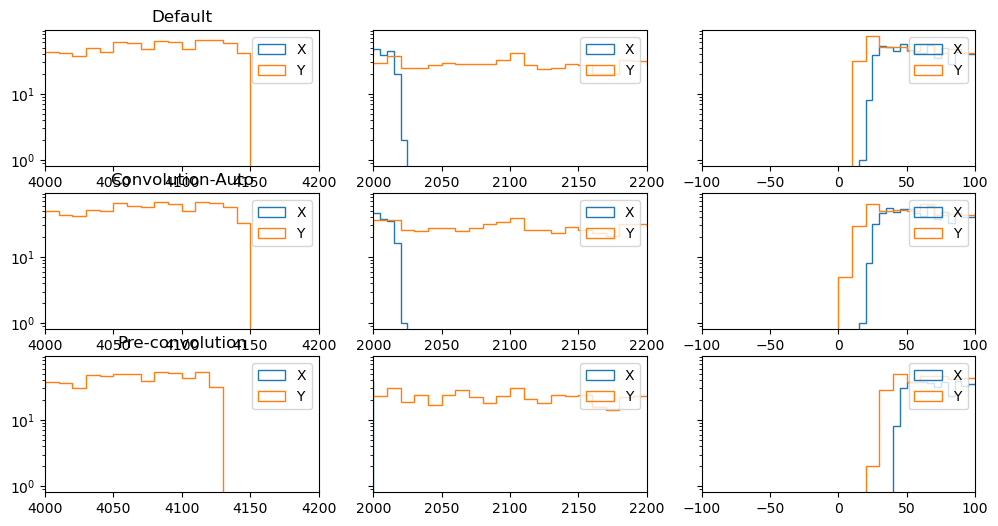

<Figure size 640x480 with 0 Axes>

In [88]:
fig, axes = plt.subplots(3, 3, figsize=(12, 6), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTable = arun['srcTable']
    pulls = arun['pulls']
    goodSrc = arun['goodSrc']
    
    ax1 = axes[i_run, 0]
    ax1.hist(goodSrc.x, histtype='step', log=True, bins=np.arange(-100, 2100, 5), label='X')
    ax1.hist(goodSrc.y, histtype='step', bins=np.arange(-100, 4200, 10), label='Y')
    ax1.set_xlim(4000, 4200)
    ax1.legend(loc='best')
    ax1.set_title(arun['run_name'])

    ax2 = axes[i_run, 1]
    ax2.hist(goodSrc.x, histtype='step', log=True, bins=np.arange(-100, 2100, 5), label='X')
    ax2.hist(goodSrc.y, histtype='step', bins=np.arange(-100, 4200, 10), label='Y')
    ax2.set_xlim(2000, 2200)
    ax2.legend(loc='best')

    ax3 = axes[i_run, 2]
    ax3.hist(goodSrc.x, histtype='step', log=True, bins=np.arange(-100, 2100, 5), label='X')
    ax3.hist(goodSrc.y, histtype='step', bins=np.arange(-100, 4200, 10), label='Y')
    ax3.set_xlim(-100, 100)
    ax3.legend(loc='best')
    
plt.show()
plt.tight_layout()

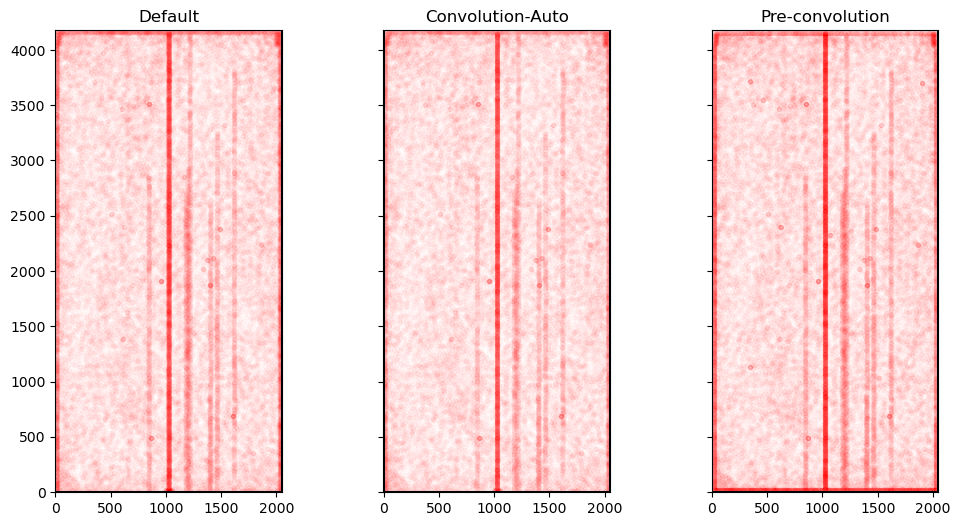

In [89]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTable = arun['srcTable']
    pulls = arun['pulls']
    goodSrc = arun['goodSrc']

    ax = axes.flatten()[i_run]
    
    ax.plot(srcTable.x, srcTable.y, 'r.', alpha=0.01)
    ax.set_xlim(-2, 2050)
    ax.set_ylim(-2, 4178)
    ax.set_aspect('equal')
    ax.hlines(xmin=0, xmax=2048, y=[0, 4176], color='black')
    ax.vlines(ymin=0, ymax=4176, x=[0, 2048], color='black')
    ax.set_title(arun['run_name'])

In [90]:
badFlagList = [
    'base_PixelFlags_flag_bad',
    'base_PixelFlags_flag_suspect',
    'base_PixelFlags_flag_saturatedCenter',
    'base_PixelFlags_flag_interpolated',
    'base_PixelFlags_flag_interpolatedCenter',
    'base_PixelFlags_flag_edge'
    ]

In [91]:
default_run['srcTable'].loc[:, 'psFluxSNR'] = (default_run['srcTable']['psFlux'] / default_run['srcTable']['psFluxErr']).values
default_run['srcTable'].loc[:, 'totFluxSNR'] = (default_run['srcTable']['totFlux'] / default_run['srcTable']['totFluxErr']).values

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [ ]:
automod_run['srcTable'].loc[:, 'psFluxSNR'] = (automod_run['srcTable']['psFlux'] / automod_run['srcTable']['psFluxErr']).values
automod_run['srcTable'].loc[:, 'totFluxSNR'] = (automod_run['srcTable']['totFlux'] / automod_run['srcTable']['totFluxErr']).values

In [ ]:
preconv_run['srcTable'].loc[:, 'psFluxSNR'] = (preconv_run['srcTable']['psFlux'] / preconv_run['srcTable']['psFluxErr']).values
preconv_run['srcTable'].loc[:, 'totFluxSNR'] = (preconv_run['srcTable']['totFlux'] / preconv_run['srcTable']['totFluxErr']).values

In [ ]:
for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTableFlags = arun['srcTableFlags']
    pulls = arun['pulls']
    goodSrc = arun['goodSrc']
    
    flagfilter = srcTableFlags[badFlagList[0]]==True
    for aflag in badFlagList[1:]:
        flagfilter = flagfilter | (srcTableFlags[aflag]==True)
    arun['flagfilter'] = flagfilter
    
    srcTable = arun['srcTable']
    # Pre-snr column:
    srcTable.loc[:, 'psFluxSNR'] = (srcTable['psFlux'] / srcTable['psFluxErr']).values
    srcTable.loc[:, 'totFluxSNR'] = (srcTable['totFlux'] / srcTable['totFluxErr']).values
    

Here we take a look at the same scatter but after applying the flag cuts. (Could be done with goodSrc as well)

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTableFlags = arun['srcTableFlags']
    pulls = arun['pulls']
    goodSrc = arun['goodSrc']
    flagfilter = arun['flagfilter'] 
    ax = axes.flatten()[i_run]
    
    ax.plot(
        srcTableFlags[~flagfilter].x, 
        srcTableFlags[~flagfilter].y, 
        'g.', alpha=0.15)

    ax.set_aspect('equal')
    ax.hlines(xmin=0, xmax=2048, y=[0, 4176], color='black')
    ax.vlines(ymin=0, ymax=4176, x=[0, 2048], color='black')
    ax.set_title(arun['run_name'])

Here we use the information on the found fakes to mark in the image where were the 
injected fakes that were lost (blue) and those that were found (red).

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTableFlags = arun['srcTableFlags']
    pulls = arun['pulls']
    matchedDiaSources = arun['matchedDiaSources']
    flagfilter = arun['flagfilter'] 
    
    lost = matchedDiaSources[~matchedDiaSources.matched]
    found = matchedDiaSources[matchedDiaSources.matched]

    ax = axes.flatten()[i_run]
    
    ax.plot(found.x_x, found.y_x, 'b.', alpha=0.25)
    ax.plot(lost.x_x, lost.y_x, 'ro', alpha=0.75)

    ax.set_aspect('equal')
    ax.hlines(xmin=0, xmax=2048, y=[0, 4176], color='black')
    ax.vlines(ymin=0, ymax=4176, x=[0, 2048], color='black')
    ax.set_title(arun['run_name'])    

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    srcTableFlags = arun['srcTableFlags']
    matchedDiaSources = arun['matchedDiaSources']
    
    lost = matchedDiaSources[~matchedDiaSources.matched]
    found = matchedDiaSources[matchedDiaSources.matched]
    
    A = (np.max(found.x_x) - np.min(found.x_x))*(np.max(found.y_x) - np.min(found.y_x))
    AMAX_1 = 4196.*2048
    X_cen = 2048/2.
    Y_cen = 4196/2.
    Y_scale = 4196/2048.

    X = np.abs(found.x_x.values - X_cen)
    Y = np.abs(found.y_x.values - Y_cen)/Y_scale

    xy = Y.copy()
    xy[np.where(X>Y)] = X[np.where(X>Y)]

    A = 4 * xy * xy
    AMAX_2 = 4096.**2

    AREAFRAC_1 = 2*A/AMAX_1
    AREAFRAC_2 = A/AMAX_2

    xy = Y.copy()
    xy[np.where(X>Y)] = X[np.where(X>Y)]

    A = 4 * xy * xy
    AMAX_2 = 4096.**2

    AREAFRAC_1 = 2*A/AMAX_1
    AREAFRAC_2 = A/AMAX_2
    
    ax = axes.flatten()[i_run]
    
    ax.hist(AREAFRAC_1, bins=50)
    ax.set_xlabel('AREAFRAC')
    ax.set_title(arun['run_name']) 
    
    arun['area_frac_found'] = AREAFRAC_1
    

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    srcTableFlags = arun['srcTableFlags']
    matchedDiaSources = arun['matchedDiaSources']
    goodSrc = arun['goodSrc']
    
    A = (np.max(goodSrc.x) - np.min(goodSrc.x))*(np.max(goodSrc.y) - np.min(goodSrc.y))
    AMAX_1 = 4196.*2048
    
    X_cen = 2048/2.
    Y_cen = 4196/2.
    Y_scale = 4196/2048.

    X = np.abs(goodSrc.x.values - X_cen)
    Y = np.abs(goodSrc.y.values - Y_cen)/Y_scale
    
    xy = Y.copy()
    xy[np.where(X>Y)] = X[np.where(X>Y)]

    A = 4 * xy * xy
    AMAX_2 = 4096.**2

    AREAFRAC_1 = 2*A/AMAX_1
    AREAFRAC_2 = A/AMAX_2   
    
    ax = axes.flatten()[i_run]
    
    ax.hist(AREAFRAC_1, bins=50)
    ax.set_xlabel('AREAFRAC')
    ax.set_title(arun['run_name']) 
    
    arun['area_frac_goodsrc'] = AREAFRAC_1

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    srcTableFlags = arun['srcTableFlags']
    matchedDiaSources = arun['matchedDiaSources']
    goodSrc = arun['srcTable']
    
    goodSrcFltr = (goodSrc.x >= 0) & (goodSrc.y >= 0) & (goodSrc.x <= 2048) & (goodSrc.y <=4196)
    goodSrc = goodSrc[goodSrcFltr]
    
    A = (np.max(goodSrc.x) - np.min(goodSrc.x))*(np.max(goodSrc.y) - np.min(goodSrc.y))
    AMAX_1 = 4196.*2048
    
    X_cen = 2048/2.
    Y_cen = 4196/2.
    Y_scale = 4196/2048.

    X = np.abs(goodSrc.x.values - X_cen)
    Y = np.abs(goodSrc.y.values - Y_cen)/Y_scale
    
    xy = Y.copy()
    xy[np.where(X>Y)] = X[np.where(X>Y)]

    A = 4 * xy * xy
    AMAX_2 = 4096.**2

    AREAFRAC_1 = 2*A/AMAX_1
    AREAFRAC_2 = A/AMAX_2   
    
    ax = axes.flatten()[i_run]
    
    ax.hist(AREAFRAC_1, bins=50)
    ax.set_xlabel('AREAFRAC')
    ax.set_title(arun['run_name']) 
    
    arun['area_frac_allsource'] = AREAFRAC_1

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    area_frac_allsource = arun['area_frac_allsource']
    area_frac_goodsrc = arun['area_frac_goodsrc']
    area_frac_found = arun['area_frac_found']

    ax = axes.flatten()[i_run]
    ax.hist(area_frac_allsource, bins=20, log=False, label='all diaSource', histtype='step', lw=2)
    ax.hist(area_frac_goodsrc, bins=20, label='clean diaSource', histtype='step', lw=2)
    ax.hist(area_frac_found, bins=20, label='Found fake', histtype='step', lw=2)

    ax.set_xlabel('Fraction of area F_A')
    ax.legend(loc='upper left')
    ax.set_title(arun['run_name'])

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=False, sharey=True)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    area_frac_allsource = arun['area_frac_allsource']
    area_frac_goodsrc = arun['area_frac_goodsrc']
    area_frac_found = arun['area_frac_found']

    ax = axes.flatten()[i_run]
    ax.hist(area_frac_allsource, bins=20, log=True, label='all diaSource', histtype='step', lw=2)
    ax.hist(area_frac_goodsrc, bins=20, label='clean diaSource', histtype='step', lw=2)
    ax.hist(area_frac_found, bins=20, label='Found fake', histtype='step', lw=2)

    ax.set_xlabel('Fraction of area F_A')
    ax.legend(loc='upper left', fontsize=8)
    ax.set_title(arun['run_name'])

In [ ]:
binsize=64+32
bins2d = [np.arange(0, 2048, binsize), np.arange(0, 4196, binsize)]
fig, axes = plt.subplots(3, 3, figsize=(8, 12), sharex=False, sharey=False)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTableFlags = arun['srcTableFlags']
    pulls = arun['pulls']
    matchedDiaSources = arun['matchedDiaSources']
    flagfilter = arun['flagfilter'] 
    
    lost = matchedDiaSources[~matchedDiaSources.matched]
    found = matchedDiaSources[matchedDiaSources.matched]

    ax_lost = axes[i_run, 0]
    ax_found = axes[i_run, 1]
    ax_eff = axes[i_run, 2]
    
    
    lcounts, lxbins, lybins, lmesh = ax_lost.hist2d(
        lost.x_x, lost.y_x, 
        bins=bins2d)
    ax_lost.set_aspect(1)
    ax_lost.set_title(arun['run_name']+' Lost')
    ax_lost.set_xlabel('x')
    ax_lost.set_ylabel('y')
    #plt.colorbar()
    
    fcounts, fxbins, fybins, fmesh = ax_found.hist2d(
        found.x_x, found.y_x,
        bins=bins2d)
    ax_found.set_aspect(1)
    ax_found.set_title(arun['run_name']+' Found')
    ax_found.set_xlabel('x')
    ax_found.set_ylabel('y')
    #plt.colorbar()
    
    fractional_eff = fcounts/(lcounts+fcounts)
    fractional_eff[np.isnan(fractional_eff)] = 0
    
    ax_eff.imshow(fractional_eff.T, origin='lower')
    ax_eff.set_aspect(1)
    ax_eff.set_title(arun['run_name']+' Eff')
    ax_eff.set_xlabel('x')
    ax_eff.set_ylabel('y')
    #plt.colorbar()
plt.tight_layout()

### 17. Flux SNR comparisons

In [ ]:
binwidth=100

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTable = arun['srcTable']
    pulls = arun['pulls']
    matchedDiaSources = arun['matchedDiaSources']
    flagfilter = arun['flagfilter'] 
 
    ax = axes.flatten()[i_run]

    plt.yscale('log')
    for band, color in zip(bandList, colorList):
        data = srcTable.loc[srcTable.filterName==band, 'psFluxSNR']
        psFluxHist = ax.hist(data, bins=range(0, int(max(data)) + binwidth, binwidth), 
                             color=color, alpha=0.5, label=band, histtype='step',
                             log=True)
    ax.set_title(arun['run_name'])
    ax.legend()
#plt.title(f'Approximate SNR distribution for difference image fluxes, {month} {year}')
    ax.set_xlabel('psFlux/psFluxErr')

In [ ]:
binwidth=100

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=False, sharey=False)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTable = arun['srcTable']
    pulls = arun['pulls']
    matchedDiaSources = arun['matchedDiaSources']
    flagfilter = arun['flagfilter'] 
 
    ax = axes.flatten()[i_run]

    plt.yscale('log')
    for band, color in zip(bandList, colorList):
        data = srcTable.loc[srcTable.filterName==band, 'totFluxSNR']
        psFluxHist = ax.hist(data, bins=range(0, int(max(data)) + binwidth, binwidth), 
                             color=color, alpha=0.5, label=band, histtype='step',
                             log=True)
    ax.set_title(arun['run_name'])
    ax.legend()
#plt.title(f'Approximate SNR distribution for difference image fluxes, {month} {year}')
    ax.set_xlabel('totFlux/totFluxErr')

In [ ]:
srcTable = default_run['srcTable']

fig, (axh, axc) = plt.subplots(1, 2, figsize=(9, 4))

for aflt, asrctab in srcTable.groupby('filterName'):
    vgrp = asrctab.groupby('ccdVisitId')
    nDiaSources = vgrp['psFlux'].agg(len)
    
    axh.hist(nDiaSources, bins=30, label=aflt)
    
    axc.hist(nDiaSources, bins=30, cumulative=True, label=aflt)

axh.set_xlabel("Number of DIASource Detections per CCD")
axh.set_ylabel("Number of ccdVisits")

axc.set_xlabel("Number of DIASource Detections per CCD")
axc.set_ylabel("Fraction of ccdVisits with fewer DIASources")
plt.legend(loc='best')
plt.suptitle(default_run['run_name'])

### 18.Number of detections 

In [ ]:
srcTable = preconv_run['srcTable']

fig, (axh, axc) = plt.subplots(1, 2, figsize=(9, 4))

for aflt, asrctab in srcTable.groupby('filterName'):
    vgrp = asrctab.groupby('ccdVisitId')
    nDiaSources = vgrp['psFlux'].agg(len)
    
    axh.hist(nDiaSources, bins=30, label=aflt)
    
    axc.hist(nDiaSources, bins=30, cumulative=True, label=aflt)

axh.set_xlabel("Number of DIASource Detections per CCD")
axh.set_ylabel("Number of ccdVisits")

axc.set_xlabel("Number of DIASource Detections per CCD")
axc.set_ylabel("Fraction of ccdVisits with fewer DIASources")
plt.legend(loc='best')
plt.suptitle(preconv_run['run_name'])

In [ ]:
srcTable = automod_run['srcTable']

fig, (axh, axc) = plt.subplots(1, 2, figsize=(9, 4))

for aflt, asrctab in srcTable.groupby('filterName'):
    vgrp = asrctab.groupby('ccdVisitId')
    nDiaSources = vgrp['psFlux'].agg(len)
    
    axh.hist(nDiaSources, bins=30, label=aflt)
    
    axc.hist(nDiaSources, bins=30, cumulative=True, label=aflt)

axh.set_xlabel("Number of DIASource Detections per CCD")
axh.set_ylabel("Number of ccdVisits")

axc.set_xlabel("Number of DIASource Detections per CCD")
axc.set_ylabel("Fraction of ccdVisits with fewer DIASources")
plt.legend(loc='best')
plt.suptitle(automod_run['run_name'])

## D. Template PSF

### 19. PSF of Calexp vs Templates

Loading tables with the PSF sizes of both science and template images.

In [ ]:
psfsizes = pd.read_csv('../data/psf_sizes_table.csv')

In [ ]:
psfsizes.head()

In [ ]:
# assuming circular size == area = 2 pi r **2
# the equiv radious would be sqrt(nea/2pi)
psfsizes['templ_nea_r'] = np.sqrt(psfsizes.Templ_psf_nea/(2*np.pi))
psfsizes['calexp_nea_r'] = np.sqrt(psfsizes.Calexp_psf_nea/(2*np.pi))
psfsizes['diff_nea_r'] = np.sqrt(psfsizes.Diff_psf_nea/(2*np.pi))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
bandax = {'r': axes[1], 'g': axes[0]}
for aflt, agroup in psfsizes.groupby('band'):
    ax = bandax[aflt]
    bins = np.arange(agroup.templ_nea_r.min()-0.1, agroup.calexp_nea_r.max()+0.1, 0.05)
    ax.set_title(aflt)
    ax.hist(agroup['templ_nea_r'], bins=bins, 
            histtype='step', lw=2, label='Template')
    ax.hist(agroup['calexp_nea_r'], bins=bins+0.05, 
            histtype='step', lw=2, label='Science')
    ax.set_xlabel('PSF NEA Circular radius')
    plt.legend(loc='upper right')

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
bandax = {'r': axes[1], 'g': axes[0]}
for aflt, agroup in psfsizes.groupby('band'):
    ax = bandax[aflt]
    bins = np.arange(-0.2, 1., 0.05)
    ax.set_title(aflt)
    ax.hist(agroup['calexp_nea_r'] - agroup['templ_nea_r'], bins=bins, 
            histtype='step', lw=2)
    ax.set_xlabel('R_science - R_template')
    plt.legend(loc='upper right')
    

In [ ]:
psfsizes['delta_psf'] = psfsizes['calexp_nea_r'] - psfsizes['templ_nea_r']

In [ ]:
psfsizes.sort_values('delta_psf')

### 20. Number of detections and flagged detections

In [ ]:
symbol = {'r': '.', 'g': 'x'}
fig, axes = plt.subplots(3, 2, figsize=(14, 8), sharex=False, sharey=False)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTableFlags = arun['srcTableFlags']
    srcTable = arun['srcTable']
    goodSrc = arun['goodSrc']
    matchedDiaSources = arun['matchedDiaSources']
    flagfilter = arun['flagfilter'] 
  
    ndiasrc = []
    ngoodiasrc = []
    
    for irow, arow in psfsizes.iterrows():
        ndiasrc.append(len(
            srcTable[(srcTable.visit==arow.visit)&(srcTable.detector==arow.detector)]
        ))
        ngoodiasrc.append(len(
            goodSrc[(goodSrc.visit==arow.visit)&(goodSrc.detector==arow.detector)]
        ))

    axreg, axlog = axes[i_run, :]
    
    psfsizes[f"ndiasrc_{arun['run_name']}"] = ndiasrc
    psfsizes[f"ngoodiasrc_{arun['run_name']}"] = ngoodiasrc
    
    for aflt, agroup in psfsizes.groupby('band'):

        axreg.plot(agroup['delta_psf'], agroup[f"ndiasrc_{arun['run_name']}"], 
                 'r'+symbol[aflt], label=aflt+' diaSrc', alpha=0.5)
        axreg.plot(agroup['delta_psf'], agroup[f"ngoodiasrc_{arun['run_name']}"], 
                 'g'+symbol[aflt], label=aflt+' Good diaSrc', alpha=0.5)
    
        axlog.plot(agroup['delta_psf'], agroup[f"ndiasrc_{arun['run_name']}"], 
                 'r'+symbol[aflt], label=aflt+' diaSrc', alpha=0.5)
        axlog.plot(agroup['delta_psf'], agroup[f"ngoodiasrc_{arun['run_name']}"], 
                 'g'+symbol[aflt], label=aflt+' Good diaSrc', alpha=0.5)

    axreg.legend(loc='best')
    axreg.set_ylabel('N')
    axreg.set_xlabel('R_science - R_template')
    
    axlog.set_yscale('log')
    axlog.legend(loc='best')
    axlog.set_ylabel('N')
    axlog.set_xlabel('R_science - R_template')
    
    axreg.set_title(arun['run_name'])
plt.tight_layout()

In [ ]:
for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    repo = arun['repo']
    srcTableFlags = arun['srcTableFlags']
    srcTable = arun['srcTable']
    matchedDiaSources = arun['matchedDiaSources']
    flagfilter = arun['flagfilter'] 

    for irow, arow in psfsizes.iterrows():
        selection = (matchedDiaSources.visit==arow.visit)&\
            (matchedDiaSources.detector==arow.detector)
        matchedDiaSources.loc[selection, 'delta_psf'] = arow.delta_psf
        matchedDiaSources.loc[selection, 'Templ_psf_nea'] = arow.Templ_psf_nea
        matchedDiaSources.loc[selection, 'Calexp_psf_nea'] = arow.Calexp_psf_nea
        matchedDiaSources.loc[selection, 'Diff_psf_nea'] = arow.Diff_psf_nea
        matchedDiaSources.loc[selection, 'templ_nea_r'] = arow.templ_nea_r
        matchedDiaSources.loc[selection, 'calexp_nea_r'] = arow.calexp_nea_r
        matchedDiaSources.loc[selection, 'diff_nea_r'] = arow.diff_nea_r


### 21. Delta magnitudes vs delta PSF difference 

Delta PSF is estimated between templates and science images.

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=False, sharey=False)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    srcTable = arun['srcTable']
    matchedDiaSources = arun['matchedDiaSources']
    n_match = len(matchedDiaSources)
    
    ax = axes.flatten()[i_run]

    ax.plot(matchedDiaSources.delta_psf+np.random.random(n_match)*0.015, 
             matchedDiaSources.psf_mag - matchedDiaSources.g_mag, '.', 
            label='PSF', alpha=0.7)
    ax.plot(matchedDiaSources.delta_psf+np.random.random(n_match)*0.015, 
            matchedDiaSources.ap_mag - matchedDiaSources.g_mag, '.', 
            label='Ap', alpha=0.25)
    ax.set_ylim(-2, 2)
    ax.set_xlabel('Delta PSF Radius')
    ax.set_ylabel('Meas Mag - True Mag')
    #ax.legend(loc='best')
    ax.set_title(arun['run_name'])
plt.tight_layout()

Pull distribution and outliers for every run

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(8, 10), sharex=False, sharey=False)

for i_run, arun in enumerate([default_run, automod_run, preconv_run]):
    srcTable = arun['srcTable']
    matchedDiaSources = arun['matchedDiaSources']
    n_match = len(matchedDiaSources)
    
    pulls = arun['pulls']
    
    ax = axes.flatten()[i_run]

    outliers = np.abs(matchedDiaSources.psf_mag - matchedDiaSources.g_mag) > 0.1
    outliers = outliers & (np.abs(matchedDiaSources.psFluxSNR) > 0.5)
    ax.hist(pulls[~outliers], bins=np.arange(-50, 50, 1), label='Outlier', histtype='step', lw=2)
    ax.hist(pulls[outliers], bins=np.arange(-50, 50, 1), label='~Outlier', histtype='step', lw=2)
    #plt.xlim(-10, 10)
    ax.set_xlabel('(Meas mag - True mag)/mag_err')
    ax.legend(loc='best')